# This Notebook stores different trajectory analysis where we were mainly varying the optimizer used and the model architecture

In [1]:
# GPU-Optimized Trajectory Class
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import time
from tqdm import tqdm
from copy import deepcopy
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm


In [3]:
class ExperimentRunner:
    def __init__(self, dataset_name='MNIST', model_type='MLP'):
        self.dataset_name = dataset_name
        self.model_type = model_type
        self.results = {}
        
        # Automatically detect and use GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        if self.device.type == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"CUDA Version: {torch.version.cuda}")
            print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        
    def create_model(self):
        """Create model based on specification - GPU optimized"""
        if self.model_type == 'MLP' and self.dataset_name == 'MNIST':
            model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, 512),  
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
        elif self.model_type == 'MLP' and self.dataset_name == 'CIFAR10':
            model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3072, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 10)
            )
        else:
            raise ValueError(f"Unsupported combination: {self.model_type}, {self.dataset_name}")
        
        # Move model to GPU
        return model.to(self.device)

    
    def get_data_loaders(self, batch_size=512):  # Larger batch size for GPU
        """Get train/test data loaders - GPU optimized"""
        if self.dataset_name == 'MNIST':
            transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
            test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform)
        elif self.dataset_name == 'CIFAR10':
            transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
            test_dataset = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)
        
        # Optimize DataLoader for GPU
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4,      # More workers for faster data loading
            pin_memory=True,    # Faster GPU transfer
            persistent_workers=True  # Keep workers alive
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )
        return train_loader, test_loader
    
    def save_initial_weights(self, model, seed):
        """Save the initial weights of a model for later reuse"""
        initial_weights = []
        for param in model.parameters():
            initial_weights.append(param.clone().detach())
        return initial_weights
    
    def load_initial_weights(self, model, initial_weights):
        """Load saved initial weights into a model"""
        for param, initial_param in zip(model.parameters(), initial_weights):
            param.data.copy_(initial_param)
        return model
    
    def train_reference_model(self, epochs=30, reference_seed=None, initial_weights=None):  
        """Train a reference model starting from same initialization - GPU optimized"""
        print("Training reference model for target weights...")
        
        # Set seed to match main experiment if provided
        if reference_seed is not None:
            torch.manual_seed(reference_seed)
            np.random.seed(reference_seed)
            if self.device.type == 'cuda':
                torch.cuda.manual_seed(reference_seed)
            print(f"Reference model using seed: {reference_seed}")
        
        target_model = self.create_model()
        
        # Load the same initial weights if provided
        if initial_weights is not None:
            target_model = self.load_initial_weights(target_model, initial_weights)
            print("Reference model loaded with same initial weights as main model")
        
        train_loader, _ = self.get_data_loaders(batch_size=1024) 
        criterion = nn.CrossEntropyLoss()
        target_optimizer = optim.Adam(target_model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Use mixed precision for faster training
        scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None
        
        for epoch in tqdm(range(epochs), desc="Reference model training"):
            target_model.train()
            epoch_loss = 0
            num_batches = 0
            
            # Use more data for better reference model
            for batch_idx, (data, target) in enumerate(train_loader):
                if batch_idx > 100:  # Use more batches
                    break
                    
                # Move data to GPU
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                target_optimizer.zero_grad()
                
                # Use automatic mixed precision if available
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = target_model(data)
                        loss = criterion(output, target)
                    scaler.scale(loss).backward()
                    scaler.step(target_optimizer)
                    scaler.update()
                else:
                    output = target_model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    target_optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            if epoch % 5 == 0:
                print(f"Reference Epoch {epoch}: Avg Loss = {avg_loss:.4f}")
        print("Final Performance: Avg Loss = " + str(avg_loss))
        print("Reference model training completed!\n")
        
        # Clear GPU cache
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        
        return [param.clone().detach() for param in target_model.parameters()]
    
    def run_single_experiment(self, optimizer_name, num_epochs=50, learning_rate=0.001, seed=42, 
                            same_initialization=True):
        """Run single training experiment with trajectory tracking - GPU optimized"""
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        if self.device.type == 'cuda':
            torch.cuda.manual_seed(seed)
        
        print(f"STARTING EXPERIMENT: {optimizer_name.upper()}")
        print(f"Same initialization: {same_initialization}")
        
        # Setup
        model = self.create_model()
        
        # Save initial weights if we want same initialization
        initial_weights = None
        if same_initialization:
            initial_weights = self.save_initial_weights(model, seed)
            print("Saved initial weights for reference model")
        
        train_loader, test_loader = self.get_data_loaders()
        criterion = nn.CrossEntropyLoss()
        
        # Create optimizer with better default parameters
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'AdamW':  # Better than Adam in many cases
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        
        # Get target weights - pass seed and initial weights for same starting point
        if same_initialization:
            target_weights = self.train_reference_model(
                reference_seed=seed, 
                initial_weights=initial_weights
            )
        else:
            target_weights = self.train_reference_model()
        
        # Initialize tracker
        tracker = TrajectoryTracker(target_weights=target_weights, device=self.device)
        
        # Use mixed precision for faster training
        scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None
        
        print(f"Starting main training with {optimizer_name}...")
        start_time = time.time()
        
        # Training loop with progress tracking
        for epoch in tqdm(range(num_epochs), desc=f"{optimizer_name} Training"):
            model.train()
            epoch_loss = 0
            num_batches = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                # Move data to GPU with non_blocking for faster transfer
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                optimizer.zero_grad()
                
                # Use automatic mixed precision if available
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        loss = criterion(output, target)
                    scaler.scale(loss).backward()
                    
                    # Log metrics periodically
                    if batch_idx % 300 == 0:  # Less frequent for speed
                        tracker.log_metrics(model, loss, optimizer, epoch, batch_idx)
                    
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    
                    # Log metrics periodically
                    if batch_idx % 300 == 0:
                        tracker.log_metrics(model, loss, optimizer, epoch, batch_idx)
                    
                    optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            # Calculate average epoch loss
            avg_epoch_loss = epoch_loss / num_batches
            
            # Validation every few epochs
            if epoch % 5 == 0:
                model.eval()
                val_loss = 0
                correct = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                        if scaler is not None:
                            with torch.cuda.amp.autocast():
                                output = model(data)
                                val_loss += criterion(output, target).item()
                        else:
                            output = model(data)
                            val_loss += criterion(output, target).item()
                        pred = output.argmax(dim=1)
                        correct += pred.eq(target.view_as(pred)).sum().item()
                
                accuracy = 100. * correct / len(test_loader.dataset)
                val_avg_loss = val_loss / len(test_loader)
                
                print(f'\nEpoch {epoch+1:2d}/{num_epochs}: '
                      f'Train Loss: {avg_epoch_loss:.4f}, '
                      f'Val Loss: {val_avg_loss:.4f}, '
                      f'Accuracy: {accuracy:.2f}%')
            
            # Log epoch metrics
            model.eval()
            with torch.no_grad():
                data, target = next(iter(train_loader))
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        dummy_loss = criterion(output, target)
                else:
                    output = model(data)
                    dummy_loss = criterion(output, target)
                tracker.log_metrics(model, dummy_loss, optimizer, epoch)
        
        training_time = time.time() - start_time
        print(f"\n{optimizer_name} training completed in {training_time:.2f} seconds!")
        
        # Clear GPU cache
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        
        print("=" * 60)
        return tracker, model
    
    def run_comparison_experiment(self, optimizer_names=['SGD', 'Adam'], num_epochs=50, seed=42):
        """Run comparison between same vs different initialization"""
        results = {}
        
        print("=== COMPARISON: SAME vs DIFFERENT INITIALIZATION ===\n")
        
        for optimizer_name in optimizer_names:
            print(f"\n--- Testing {optimizer_name} ---")
            
            # Run with same initialization
            print("\n1. Same initialization:")
            tracker_same, model_same = self.run_single_experiment(
                optimizer_name, num_epochs, seed=seed, same_initialization=True
            )
            
            # Run with different initialization  
            print("\n2. Different initialization:")
            tracker_diff, model_diff = self.run_single_experiment(
                optimizer_name, num_epochs, seed=seed, same_initialization=False
            )
            
            results[optimizer_name] = {
                'same_init': tracker_same,
                'diff_init': tracker_diff
            }
            
            # Quick comparison of final alignment
            final_align_same = tracker_same.metrics['grad_alignment'][-1] if tracker_same.metrics['grad_alignment'] else 0
            final_align_diff = tracker_diff.metrics['grad_alignment'][-1] if tracker_diff.metrics['grad_alignment'] else 0
            
            print(f"\n{optimizer_name} SUMMARY:")
            print(f"Final gradient alignment - Same init: {final_align_same:.4f}")
            print(f"Final gradient alignment - Diff init: {final_align_diff:.4f}")
            print(f"Improvement: {final_align_same - final_align_diff:.4f}")
        
        return results
    
    def run_switching_experiment(self, optimizer1, optimizer2, switch_epoch, num_epochs=50, seed=42):
        """Run experiment with mid-training optimizer switch - GPU optimized"""
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        if self.device.type == 'cuda':
            torch.cuda.manual_seed(seed)
        
        print(f"SWITCHING EXPERIMENT: {optimizer1} -> {optimizer2} (switch at epoch {switch_epoch})")
        
        model = self.create_model()
        train_loader, test_loader = self.get_data_loaders()
        criterion = nn.CrossEntropyLoss()
        
        # Create first optimizer
        if optimizer1 == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
        elif optimizer1 == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        elif optimizer1 == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        elif optimizer1 == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        tracker = TrajectoryTracker(device=self.device)
        scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None
        start_time = time.time()
        
        for epoch in tqdm(range(num_epochs), desc="Switching Experiment"):
            # Switch optimizer if needed
            if epoch == switch_epoch:
                print(f"\n SWITCHING from {optimizer1} to {optimizer2} at epoch {epoch}!")
                if optimizer2 == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
                elif optimizer2 == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                elif optimizer2 == 'AdamW':
                    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
                elif optimizer2 == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
                
                tracker.switch_optimizer(optimizer, epoch)
            
            # Training loop
            model.train()
            epoch_loss = 0
            num_batches = 0
            
            current_opt = optimizer2 if epoch >= switch_epoch else optimizer1
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                optimizer.zero_grad()
                
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        loss = criterion(output, target)
                    scaler.scale(loss).backward()
                    
                    if batch_idx % 300 == 0:
                        tracker.log_metrics(model, loss, optimizer, epoch, batch_idx)
                    
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    
                    if batch_idx % 300 == 0:
                        tracker.log_metrics(model, loss, optimizer, epoch, batch_idx)
                    
                    optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            avg_epoch_loss = epoch_loss / num_batches
            print(f'Epoch {epoch+1:2d}/{num_epochs} ({current_opt}): Train Loss: {avg_epoch_loss:.4f}')
        
        training_time = time.time() - start_time
        print(f"\nSwitching experiment completed in {training_time:.2f} seconds!")
        
        # Clear GPU cache
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        
        print("=" * 60)
        return tracker, model

Starting loss landscape visualization experiments...
Choose experiment to run:
1. Simple experiment (Adam only)
2. Compare optimizers (SGD vs Adam)
3. Test different parameters
4. Comprehensive analysis (all optimizers)

SIMPLE EXPERIMENT
Running simple experiment with fixed loss landscape visualization...
Using device: cuda
GPU: NVIDIA GeForce RTX 2070
CUDA Version: 12.1
Available GPU memory: 8.6 GB
STARTING EXPERIMENT WITH REFERENCE TRACKING: ADAM
Same initialization: True
Create landscape: True
Saved initial weights for reference model
Training reference model and capturing its trajectory...
Training reference model for target weights with trajectory tracking...
Reference model using seed: 42
Reference model loaded with same initial weights as main model


C:\Users\Alexander\AppData\Local\Temp\ipykernel_17980\956206751.py:818: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None
Reference model training:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\Alexander\AppData\Local\Temp\ipykernel_17980\956206751.py:841: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Reference model training:   3%|▎         | 1/30 [00:06<03:20,  6.93s/it]

Reference Epoch 0: Avg Loss = 0.4933


Reference model training:  20%|██        | 6/30 [00:22<01:19,  3.32s/it]

Reference Epoch 5: Avg Loss = 0.0473


Reference model training:  37%|███▋      | 11/30 [00:38<01:01,  3.26s/it]

Reference Epoch 10: Avg Loss = 0.0162


Reference model training:  53%|█████▎    | 16/30 [00:55<00:47,  3.37s/it]

Reference Epoch 15: Avg Loss = 0.0070


Reference model training:  70%|███████   | 21/30 [01:13<00:32,  3.56s/it]

Reference Epoch 20: Avg Loss = 0.0023


Reference model training:  87%|████████▋ | 26/30 [01:31<00:14,  3.65s/it]

Reference Epoch 25: Avg Loss = 0.0036


Reference model training: 100%|██████████| 30/30 [01:45<00:00,  3.53s/it]


Final Performance: Avg Loss = 0.012079097220074322
Reference model training completed!



C:\Users\Alexander\AppData\Local\Temp\ipykernel_17980\956206751.py:934: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None


Starting main training with Adam...


Adam Training:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\Alexander\AppData\Local\Temp\ipykernel_17980\956206751.py:953: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Alexander\AppData\Local\Temp\ipykernel_17980\956206751.py:990: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Alexander\AppData\Local\Temp\ipykernel_17980\956206751.py:1013: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Adam Training:   5%|▌         | 1/20 [00:11<03:45, 11.87s/it]


Epoch  1/20: Train Loss: 0.3596, Val Loss: 0.1752, Accuracy: 94.79%


Adam Training:  30%|███       | 6/20 [00:31<01:01,  4.39s/it]


Epoch  6/20: Train Loss: 0.0317, Val Loss: 0.0708, Accuracy: 97.81%


Adam Training:  55%|█████▌    | 11/20 [00:51<00:37,  4.13s/it]


Epoch 11/20: Train Loss: 0.0128, Val Loss: 0.0748, Accuracy: 98.01%


Adam Training:  80%|████████  | 16/20 [01:10<00:16,  4.04s/it]


Epoch 16/20: Train Loss: 0.0071, Val Loss: 0.0853, Accuracy: 97.92%


Adam Training: 100%|██████████| 20/20 [01:25<00:00,  4.28s/it]



Adam training completed in 85.70 seconds!

Creating loss landscape visualization with both trajectories...
Creating improved loss landscape visualization...
Adaptive range scale: 0.0869
Trajectory alpha range: [-0.0034, 0.0481]
Trajectory beta range: [-0.0579, 0.0039]
Computing loss surface on grid 30x30...


Grid evaluation: 100%|██████████| 900/900 [07:05<00:00,  2.12it/s]



Loss surface statistics:
  Min loss: 0.002755
  Max loss: 0.011349
  Mean loss: 0.005903
  Std loss: 0.001401
  Grid shape: (30, 30)
  Alpha range: [-0.0869, 0.0869]
  Beta range: [-0.0869, 0.0869]
  Using trajectory offset: 0.000172
  Main trajectory loss range: [0.004032, 0.008787]
  Reference trajectory loss range: [0.004411, 0.008944]
Enhanced loss landscape plot saved to Adam_fixed_loss_landscape.png


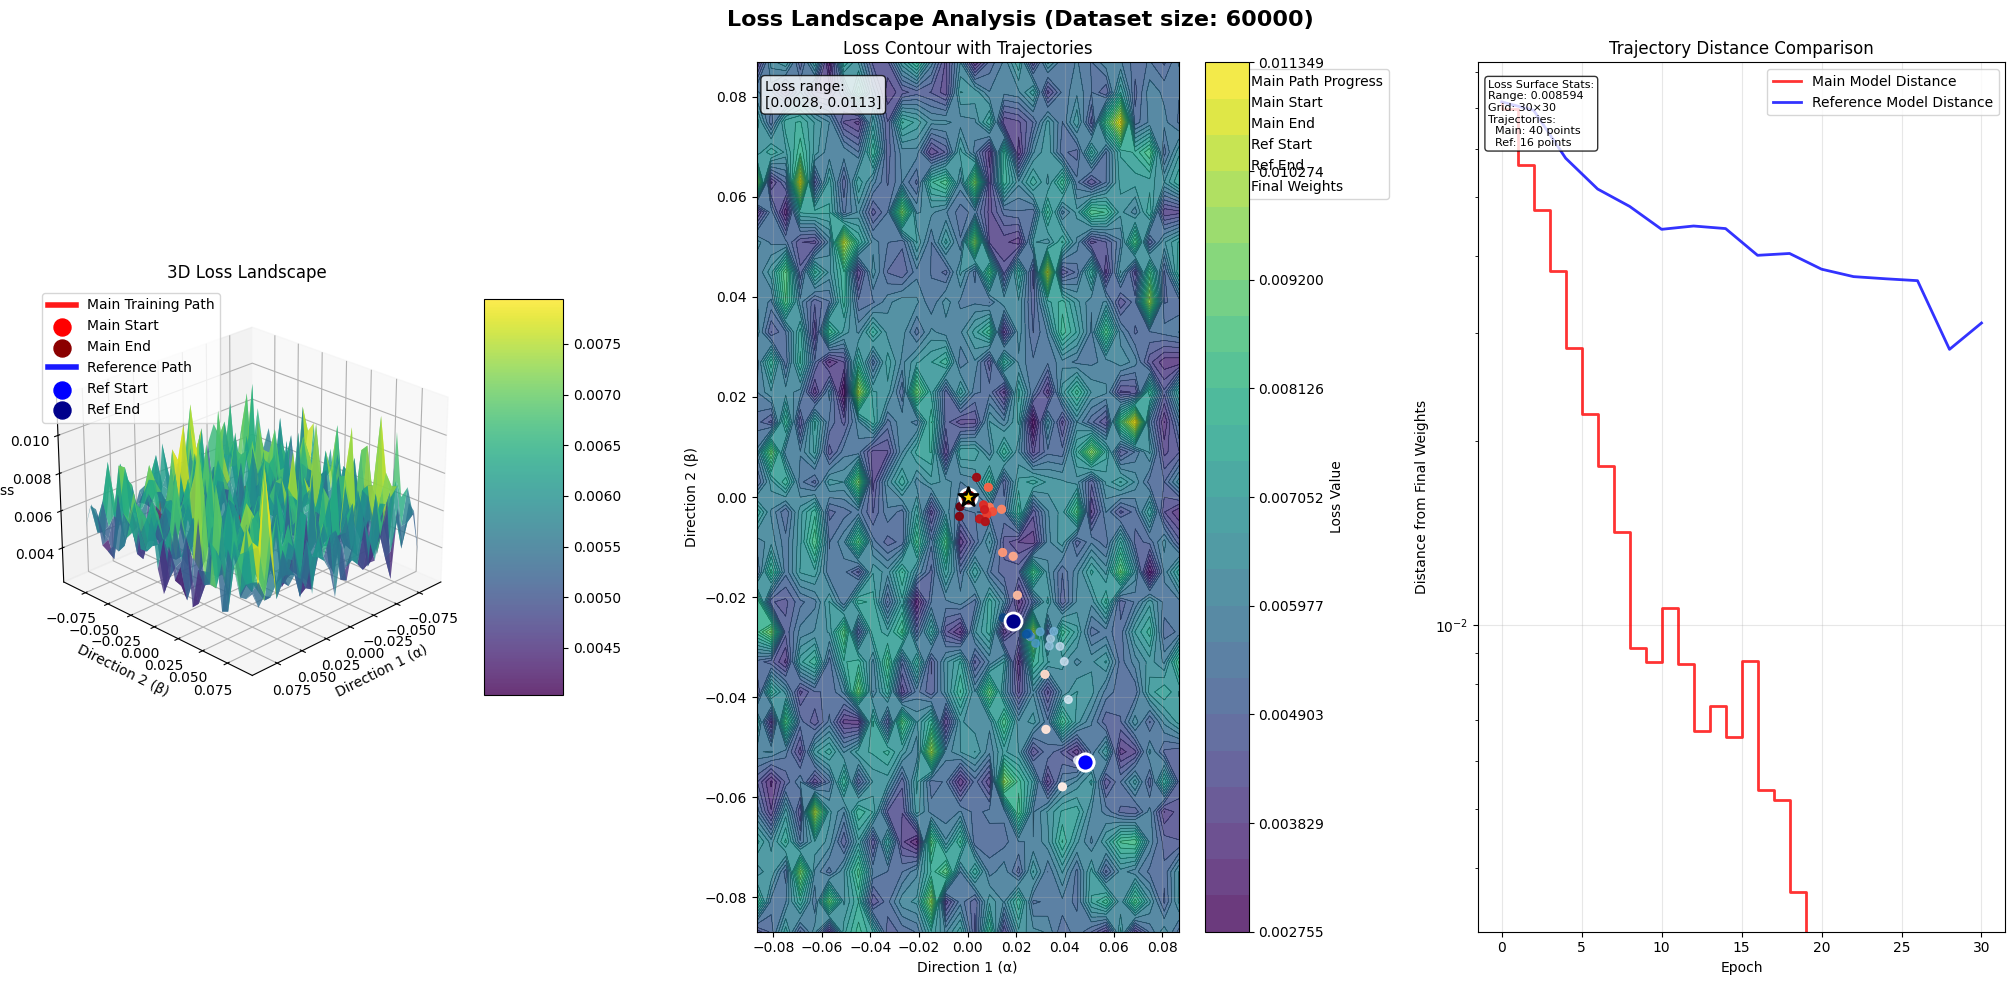

ValueError: x and y must have same first dimension, but have shapes (40,) and (39,)

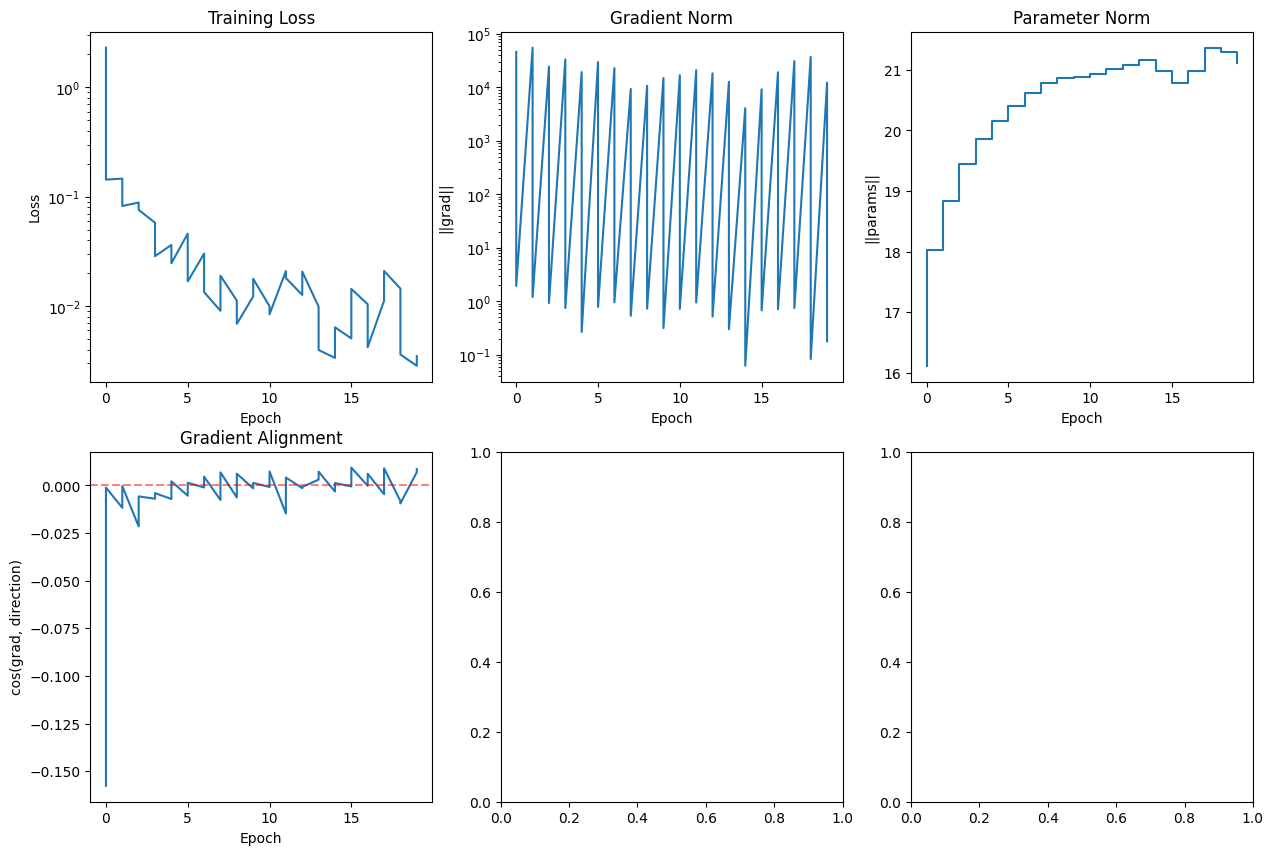

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import pickle
import time
from scipy.interpolate import RegularGridInterpolator

class EnhancedTrajectoryTracker:
    """Enhanced version that tracks both main and reference model trajectories for comparison"""
    
    def __init__(self, track_hessian=False, target_weights=None, device='cuda', track_weights=False):  
        self.metrics = defaultdict(list)
        self.track_hessian = track_hessian
        self.target_weights = target_weights
        self.switch_epoch = None
        self.device = device
        
        # Weight trajectory tracking for main model
        self.track_weights = track_weights
        self.weight_trajectory = []  # Store flattened weights at each logging step
        self.trajectory_epochs = []  # Store corresponding epochs
        
        # Reference model trajectory tracking
        self.reference_trajectory = []  # Store reference model weights during training
        self.reference_epochs = []     # Store corresponding epochs for reference model
        
        # Move target weights to GPU if available
        if self.target_weights is not None:
            self.target_weights = [w.to(device) for w in self.target_weights]
    
    def get_weights(self, model):
        """Flatten all model weights into a single vector"""
        return torch.cat([p.data.view(-1) for p in model.parameters()])
    
    def set_weights(self, model, flat_weights):
        """Set model weights from a flattened vector"""
        idx = 0
        for p in model.parameters():
            shape = p.data.size()
            numel = p.data.numel()
            p.data = flat_weights[idx:idx+numel].view(shape).clone()
            idx += numel
    
    def log_reference_weights(self, model, epoch):
        """Log reference model weights during training"""
        if self.track_weights:
            weights_flat = self.get_weights(model).cpu().clone()
            self.reference_trajectory.append(weights_flat)
            self.reference_epochs.append(epoch)
    
    def compute_gradient_alignment(self, model):
        """Compute alignment between current gradient and direction to target - GPU optimized"""
        if self.target_weights is None:
            return 0.0
            
        # Get current gradient
        grad_vec = []
        for param in model.parameters():
            if param.grad is not None:
                grad_vec.append(param.grad.flatten())
        
        if not grad_vec:
            return 0.0
            
        current_grad = torch.cat(grad_vec)
        
        # Get direction to target
        direction_vec = []
        current_params = []
        
        for param, target_param in zip(model.parameters(), self.target_weights):
            current_params.append(param.flatten())
            direction_vec.append((target_param - param).flatten())
        
        direction = torch.cat(direction_vec)
        
        # Compute cosine similarity on GPU
        grad_norm = torch.norm(current_grad)
        dir_norm = torch.norm(direction)
        
        if grad_norm == 0 or dir_norm == 0:
            return 0.0
        
        cosine_sim = torch.dot(current_grad, direction) / (grad_norm * dir_norm)
        return cosine_sim.item()
    
    def compute_hessian_trace_approx(self, model, loss, num_samples=3):
        """Approximate Hessian trace using Hutchinson's estimator - GPU optimized"""
        if not self.track_hessian:
            return 0.0
        
        if not loss.requires_grad:
            return 0.0
            
        trace_estimate = 0.0
        
        try:
            for _ in range(num_samples):
                # Random Rademacher vector on GPU
                z = []
                for param in model.parameters():
                    if param.requires_grad:
                        z_param = torch.randint_like(param, 0, 2, device=self.device).float() * 2 - 1
                        z.append(z_param)
                
                if not z:
                    return 0.0
                
                # Compute Hessian-vector product
                grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
                
                Hv = torch.tensor(0.0, device=self.device)
                for g, z_param in zip(grad_params, z):
                    if g is not None:
                        Hv += torch.sum(g * z_param)
                
                if Hv == 0.0:
                    continue
                
                # Second derivative
                grad2_params = torch.autograd.grad(Hv, model.parameters(), retain_graph=True)
                
                # z^T * H * z
                trace_sample = 0.0
                for g2, z_param in zip(grad2_params, z):
                    if g2 is not None:
                        trace_sample += torch.sum(g2 * z_param).item()
                
                trace_estimate += trace_sample
                
        except RuntimeError as e:
            print(f"Hessian computation error: {e}")
            return 0.0
        
        return trace_estimate / num_samples
    
    def log_metrics(self, model, loss, optimizer, epoch, batch_idx=None):
        """Log all trajectory metrics for current state - GPU optimized"""
        
        # Basic loss
        self.metrics['loss'].append(loss.item())
        self.metrics['epoch'].append(epoch)
        
        # Track weight trajectory if enabled
        if self.track_weights and (batch_idx is None or batch_idx % 300 == 0):
            weights_flat = self.get_weights(model).cpu().clone()
            self.weight_trajectory.append(weights_flat)
            self.trajectory_epochs.append(epoch + (batch_idx / 1000 if batch_idx else 0))
        
        # Gradient metrics - compute on GPU then move to CPU
        grad_norm_sq = torch.tensor(0.0, device=self.device)
        param_norm_sq = torch.tensor(0.0, device=self.device)
        
        for param in model.parameters():
            param_norm_sq += torch.norm(param) ** 2
            if param.grad is not None:
                grad_norm_sq += torch.norm(param.grad) ** 2
        
        self.metrics['grad_norm'].append(torch.sqrt(grad_norm_sq).item())
        self.metrics['param_norm'].append(torch.sqrt(param_norm_sq).item())
        
        # Gradient alignment (if target available)
        alignment = self.compute_gradient_alignment(model)
        self.metrics['grad_alignment'].append(alignment)
        
        # Hessian approximation (expensive, do sparingly)
        if epoch % 10 == 0 and batch_idx is None and self.track_hessian:
            try:
                hessian_trace = self.compute_hessian_trace_approx(model, loss, num_samples=3)
                self.metrics['hessian_trace'].append(hessian_trace)
                self.metrics['hessian_epoch'].append(epoch)
            except RuntimeError as e:
                print(f"Hessian computation failed at epoch {epoch}: {e}")
        
        # Optimizer-specific metrics
        if hasattr(optimizer, 'state_dict'):
            state = optimizer.state_dict()
            if 'Adam' in str(type(optimizer)):
                # Adam-specific: momentum estimates
                total_momentum = torch.tensor(0.0, device=self.device)
                total_velocity = torch.tensor(0.0, device=self.device)
                param_count = 0
                
                for group in state['state'].values():
                    if 'exp_avg' in group:
                        total_momentum += torch.norm(group['exp_avg']) ** 2
                        total_velocity += torch.norm(group['exp_avg_sq']) ** 2
                        param_count += 1
                
                if param_count > 0:
                    self.metrics['adam_momentum_norm'].append(torch.sqrt(total_momentum).item())
                    self.metrics['adam_velocity_norm'].append(torch.sqrt(total_velocity).item())
    
    def switch_optimizer(self, new_optimizer, epoch):
        """Record optimizer switch event"""
        self.switch_epoch = epoch
        self.metrics['optimizer_switch'].append(epoch)
        print(f"Optimizer switched at epoch {epoch}")
    
    def evaluate_loss_on_full_dataset(self, model, data_loader, criterion=None):
        """
        Evaluate loss on the entire dataset
        
        Args:
            model: The model to evaluate
            data_loader: DataLoader containing the full dataset
            criterion: Loss function (defaults to CrossEntropyLoss)
        
        Returns:
            Average loss over the entire dataset
        """
        if criterion is None:
            criterion = nn.CrossEntropyLoss()
        
        model.eval()
        total_loss = 0.0
        total_samples = 0
        
        with torch.no_grad():
            for batch_x, batch_y in data_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                # Accumulate loss weighted by batch size
                batch_size = batch_x.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
        
        return total_loss / total_samples if total_samples > 0 else 0.0
    
    def evaluate_loss_on_sample(self, model, data_loader, criterion, num_batches=10):
        """Evaluate loss on a sample of the dataset for faster landscape computation"""
        model.eval()
        total_loss = 0.0
        total_samples = 0
        
        with torch.no_grad():
            for batch_idx, (batch_x, batch_y) in enumerate(data_loader):
                if batch_idx >= num_batches:
                    break
                    
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                batch_size = batch_x.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
        
        return total_loss / total_samples if total_samples > 0 else 0.0
    
    def create_better_loss_landscape(self, model, data_loader, final_weights=None, 
                                    grid_resolution=30, range_scale=0.05, 
                                    criterion=None, adaptive_range=True, fast_mode=True):
        """
        Create loss landscape with adaptive range and better sampling
        """
        print("Creating improved loss landscape visualization...")
        
        if criterion is None:
            criterion = nn.CrossEntropyLoss()
        
        if final_weights is None:
            final_weights = self.get_weights(model)
        
        # Generate orthogonal directions with better initialization
        direction_1 = torch.randn_like(final_weights)
        direction_1 /= direction_1.norm()
        
        direction_2 = torch.randn_like(final_weights)
        direction_2 -= torch.dot(direction_1, direction_2) * direction_1
        direction_2 /= direction_2.norm()
        
        # Adaptive range calculation if enabled
        if adaptive_range and self.weight_trajectory:
            # Calculate range based on trajectory spread
            trajectory_alphas = []
            trajectory_betas = []
            for weights in self.weight_trajectory:
                weights = weights.to(self.device)
                diff = weights - final_weights
                alpha_proj = torch.dot(diff, direction_1).item()
                beta_proj = torch.dot(diff, direction_2).item()
                trajectory_alphas.append(alpha_proj)
                trajectory_betas.append(beta_proj)
            
            alpha_range = max(abs(min(trajectory_alphas)), abs(max(trajectory_alphas)))
            beta_range = max(abs(min(trajectory_betas)), abs(max(trajectory_betas)))
            
            # Use trajectory range with some padding
            adaptive_scale = max(alpha_range, beta_range) * 1.5
            range_scale = max(range_scale, adaptive_scale)
            
            print(f"Adaptive range scale: {range_scale:.4f}")
            print(f"Trajectory alpha range: [{min(trajectory_alphas):.4f}, {max(trajectory_alphas):.4f}]")
            print(f"Trajectory beta range: [{min(trajectory_betas):.4f}, {max(trajectory_betas):.4f}]")
        
        # Create grid
        alphas = np.linspace(-range_scale, range_scale, grid_resolution)
        betas = np.linspace(-range_scale, range_scale, grid_resolution)
        loss_surface = np.zeros((len(alphas), len(betas)))
        
        # Create a temporary model for evaluation
        model_temp = deepcopy(model)
        
        print(f"Computing loss surface on grid {grid_resolution}x{grid_resolution}...")
        total_points = len(alphas) * len(betas)
        
        with tqdm(total=total_points, desc="Grid evaluation") as pbar:
            for i, alpha in enumerate(alphas):
                for j, beta in enumerate(betas):
                    # Compute weights at this grid point
                    w = final_weights + alpha * direction_1 + beta * direction_2
                    self.set_weights(model_temp, w)
                    
                    # Evaluate loss
                    if fast_mode:
                        loss_value = self.evaluate_loss_on_sample(model_temp, data_loader, criterion, num_batches=5)
                    else:
                        loss_value = self.evaluate_loss_on_full_dataset(model_temp, data_loader, criterion)
                    
                    loss_surface[i, j] = loss_value
                    
                    pbar.update(1)
                    
                    # Memory cleanup
                    if (i * len(betas) + j + 1) % 20 == 0:
                        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Project trajectories
        main_trajectory_2d = []
        if self.weight_trajectory:
            for weights in self.weight_trajectory:
                weights = weights.to(self.device)
                diff = weights - final_weights
                alpha_proj = torch.dot(diff, direction_1).item()
                beta_proj = torch.dot(diff, direction_2).item()
                main_trajectory_2d.append((alpha_proj, beta_proj))
        
        reference_trajectory_2d = []
        if self.reference_trajectory:
            for weights in self.reference_trajectory:
                weights = weights.to(self.device)
                diff = weights - final_weights
                alpha_proj = torch.dot(diff, direction_1).item()
                beta_proj = torch.dot(diff, direction_2).item()
                reference_trajectory_2d.append((alpha_proj, beta_proj))
        
        return {
            'alphas': alphas,
            'betas': betas,
            'loss_surface': loss_surface,
            'main_trajectory_2d': main_trajectory_2d,
            'reference_trajectory_2d': reference_trajectory_2d,
            'main_trajectory_epochs': self.trajectory_epochs.copy(),
            'reference_trajectory_epochs': self.reference_epochs.copy(),
            'final_weights_2d': (0, 0),
            'direction_1': direction_1,
            'direction_2': direction_2,
            'range_scale': range_scale,
            'dataset_size': len(data_loader.dataset) if hasattr(data_loader, 'dataset') else 'Unknown'
        }
    
    def plot_loss_landscape_with_both_trajectories_fixed(self, landscape_data, save_path=None, figsize=(20, 10)):
        """
        Fixed version of the loss landscape plotting with proper loss interpolation and scaling
        """
        alphas = landscape_data['alphas']
        betas = landscape_data['betas']
        loss_surface = landscape_data['loss_surface']
        main_trajectory_2d = landscape_data['main_trajectory_2d']
        reference_trajectory_2d = landscape_data['reference_trajectory_2d']
        main_epochs = landscape_data['main_trajectory_epochs']
        reference_epochs = landscape_data['reference_trajectory_epochs']
        dataset_size = landscape_data.get('dataset_size', 'Unknown')
        
        # Create meshgrid for plotting
        alphas_grid, betas_grid = np.meshgrid(alphas, betas)
        
        # Print loss surface statistics for debugging
        print(f"\nLoss surface statistics:")
        print(f"  Min loss: {np.min(loss_surface):.6f}")
        print(f"  Max loss: {np.max(loss_surface):.6f}")
        print(f"  Mean loss: {np.mean(loss_surface):.6f}")
        print(f"  Std loss: {np.std(loss_surface):.6f}")
        print(f"  Grid shape: {loss_surface.shape}")
        print(f"  Alpha range: [{np.min(alphas):.4f}, {np.max(alphas):.4f}]")
        print(f"  Beta range: [{np.min(betas):.4f}, {np.max(betas):.4f}]")
        
        # Create interpolator for accurate loss values at trajectory points
        interpolator = RegularGridInterpolator(
            (alphas, betas), loss_surface, 
            method='linear', bounds_error=False, fill_value=None
        )
        
        # Create figure with subplots
        fig = plt.figure(figsize=figsize)
        fig.suptitle(f'Loss Landscape Analysis (Dataset size: {dataset_size})', fontsize=16, fontweight='bold')
        
        # 3D surface plot
        ax1 = fig.add_subplot(131, projection='3d')
        
        # Plot loss surface with better colormap
        surf = ax1.plot_surface(alphas_grid, betas_grid, loss_surface.T, 
                               cmap='viridis', alpha=0.8, linewidth=0, antialiased=True,
                               rcount=50, ccount=50)  # Better surface resolution
        
        # Calculate adaptive offset based on loss variation
        loss_range = np.max(loss_surface) - np.min(loss_surface)
        trajectory_offset = max(loss_range * 0.02, 1e-6)  # 2% of range or minimum value
        
        print(f"  Using trajectory offset: {trajectory_offset:.6f}")
        
        # Plot main trajectory if available
        if main_trajectory_2d:
            main_alphas = [t[0] for t in main_trajectory_2d]
            main_betas = [t[1] for t in main_trajectory_2d]
            
            # Interpolate loss values accurately
            main_points = np.array([[alpha, beta] for alpha, beta in main_trajectory_2d])
            main_losses = interpolator(main_points)
            
            # Handle any NaN values
            valid_indices = ~np.isnan(main_losses)
            if np.any(valid_indices):
                main_alphas = np.array(main_alphas)[valid_indices]
                main_betas = np.array(main_betas)[valid_indices]
                main_losses = main_losses[valid_indices] + trajectory_offset
                
                print(f"  Main trajectory loss range: [{np.min(main_losses):.6f}, {np.max(main_losses):.6f}]")
                
                # Plot main trajectory
                ax1.plot(main_alphas, main_betas, main_losses, 
                        'r-', linewidth=4, alpha=0.9, label='Main Training Path')
                ax1.scatter(main_alphas[0], main_betas[0], main_losses[0], 
                           color='red', s=150, label='Main Start', zorder=10)
                ax1.scatter(main_alphas[-1], main_betas[-1], main_losses[-1], 
                           color='darkred', s=150, label='Main End', zorder=10)
            else:
                print("  Warning: All main trajectory points are outside the grid!")
        
        # Plot reference trajectory if available
        if reference_trajectory_2d:
            ref_alphas = [t[0] for t in reference_trajectory_2d]
            ref_betas = [t[1] for t in reference_trajectory_2d]
            
            # Interpolate loss values accurately
            ref_points = np.array([[alpha, beta] for alpha, beta in reference_trajectory_2d])
            ref_losses = interpolator(ref_points)
            
            # Handle any NaN values
            valid_indices = ~np.isnan(ref_losses)
            if np.any(valid_indices):
                ref_alphas = np.array(ref_alphas)[valid_indices]
                ref_betas = np.array(ref_betas)[valid_indices]
                ref_losses = ref_losses[valid_indices] + trajectory_offset * 0.5  # Slightly lower offset
                
                print(f"  Reference trajectory loss range: [{np.min(ref_losses):.6f}, {np.max(ref_losses):.6f}]")
                
                # Plot reference trajectory
                ax1.plot(ref_alphas, ref_betas, ref_losses, 
                        'b-', linewidth=4, alpha=0.9, label='Reference Path')
                ax1.scatter(ref_alphas[0], ref_betas[0], ref_losses[0], 
                           color='blue', s=150, label='Ref Start', zorder=10)
                ax1.scatter(ref_alphas[-1], ref_betas[-1], ref_losses[-1], 
                           color='darkblue', s=150, label='Ref End', zorder=10)
            else:
                print("  Warning: All reference trajectory points are outside the grid!")
        
        ax1.set_xlabel('Direction 1 (α)')
        ax1.set_ylabel('Direction 2 (β)')
        ax1.set_zlabel('Loss')
        ax1.set_title('3D Loss Landscape')
        ax1.legend()
        
        # Set better viewing angle
        ax1.view_init(elev=25, azim=45)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
        
        # 2D contour plot with better visualization
        ax2 = fig.add_subplot(132)
        
        # Create more contour levels for better visualization
        num_levels = 25
        loss_min, loss_max = np.min(loss_surface), np.max(loss_surface)
        
        # Use logarithmic spacing if loss range is large
        if loss_max / loss_min > 10:
            levels = np.logspace(np.log10(loss_min), np.log10(loss_max), num_levels)
        else:
            levels = np.linspace(loss_min, loss_max, num_levels)
        
        # Plot contour
        contour = ax2.contour(alphas_grid, betas_grid, loss_surface.T, 
                             levels=levels, colors='black', alpha=0.4, linewidths=0.5)
        contourf = ax2.contourf(alphas_grid, betas_grid, loss_surface.T, 
                               levels=levels, cmap='viridis', alpha=0.8)
        
        # Plot main trajectory
        if main_trajectory_2d and len(main_trajectory_2d) > 0:
            main_alphas = [t[0] for t in main_trajectory_2d]
            main_betas = [t[1] for t in main_trajectory_2d]
            
            # Plot path with gradient coloring by epoch
            if len(main_epochs) == len(main_alphas):
                scatter = ax2.scatter(main_alphas, main_betas, c=main_epochs, 
                                    cmap='Reds', s=30, alpha=0.8, zorder=5, 
                                    label='Main Path Progress')
            else:
                ax2.plot(main_alphas, main_betas, 'r-', linewidth=3, alpha=0.9, 
                        label='Main Path', zorder=4)
            
            ax2.scatter(main_alphas[0], main_betas[0], color='red', s=150, 
                       label='Main Start', zorder=10, edgecolor='white', linewidth=2)
            ax2.scatter(main_alphas[-1], main_betas[-1], color='darkred', s=150, 
                       label='Main End', zorder=10, edgecolor='white', linewidth=2)
        
        # Plot reference trajectory
        if reference_trajectory_2d and len(reference_trajectory_2d) > 0:
            ref_alphas = [t[0] for t in reference_trajectory_2d]
            ref_betas = [t[1] for t in reference_trajectory_2d]
            
            # Plot path with gradient coloring by epoch
            if len(reference_epochs) == len(ref_alphas):
                scatter = ax2.scatter(ref_alphas, ref_betas, c=reference_epochs, 
                                    cmap='Blues', s=30, alpha=0.8, zorder=5)
            else:
                ax2.plot(ref_alphas, ref_betas, 'b-', linewidth=3, alpha=0.9, 
                        label='Reference Path', zorder=4)
            
            ax2.scatter(ref_alphas[0], ref_betas[0], color='blue', s=150, 
                       label='Ref Start', zorder=10, edgecolor='white', linewidth=2)
            ax2.scatter(ref_alphas[-1], ref_betas[-1], color='darkblue', s=150, 
                       label='Ref End', zorder=10, edgecolor='white', linewidth=2)
        
        # Mark the final weights point (origin)
        ax2.scatter(0, 0, color='gold', s=200, marker='*', 
                   label='Final Weights', zorder=10, edgecolor='black', linewidth=2)
        
        ax2.set_xlabel('Direction 1 (α)')
        ax2.set_ylabel('Direction 2 (β)')
        ax2.set_title('Loss Contour with Trajectories')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        # Add loss value text box
        ax2.text(0.02, 0.98, f'Loss range:\n[{loss_min:.4f}, {loss_max:.4f}]', 
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add colorbar for contour
        cbar = fig.colorbar(contourf, ax=ax2)
        cbar.set_label('Loss Value')
        
        # Third subplot: Enhanced trajectory comparison
        ax3 = fig.add_subplot(133)
        
        if main_trajectory_2d and reference_trajectory_2d:
            # Calculate distances from origin (final weights) over time
            main_distances = [np.sqrt(t[0]**2 + t[1]**2) for t in main_trajectory_2d]
            ref_distances = [np.sqrt(t[0]**2 + t[1]**2) for t in reference_trajectory_2d]
            
            # Plot distance evolution
            ax3.plot(main_epochs[:len(main_distances)], main_distances, 
                    'r-', linewidth=2, label='Main Model Distance', alpha=0.8)
            ax3.plot(reference_epochs[:len(ref_distances)], ref_distances, 
                    'b-', linewidth=2, label='Reference Model Distance', alpha=0.8)
            
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Distance from Final Weights')
            ax3.set_title('Trajectory Distance Comparison')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Use log scale only if range is large enough
            if len(main_distances + ref_distances) > 0:
                distance_ratio = max(main_distances + ref_distances) / max(1e-10, min(main_distances + ref_distances))
                if distance_ratio > 10:
                    ax3.set_yscale('log')
            
            # Add comprehensive statistics
            stats_text = f"""Loss Surface Stats:
Range: {loss_range:.6f}
Grid: {len(alphas)}×{len(betas)}
Trajectories:
  Main: {len(main_trajectory_2d)} points
  Ref: {len(reference_trajectory_2d)} points"""
            
            ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, 
                    verticalalignment='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Enhanced loss landscape plot saved to {save_path}")
        
        plt.show()
    
    def plot_trajectory(self, save_path=None):
        """Generate comprehensive trajectory plots"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Loss trajectory
        axes[0,0].plot(self.metrics['epoch'], self.metrics['loss'])
        axes[0,0].set_title('Training Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].set_yscale('log')
        
        # Gradient norm
        axes[0,1].plot(self.metrics['epoch'], self.metrics['grad_norm'])
        axes[0,1].set_title('Gradient Norm')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('||grad||')
        axes[0,1].set_yscale('log')
        
        # Parameter norm
        axes[0,2].plot(self.metrics['epoch'], self.metrics['param_norm'])
        axes[0,2].set_title('Parameter Norm')
        axes[0,2].set_xlabel('Epoch')
        axes[0,2].set_ylabel('||params||')
        
        # Gradient alignment
        axes[1,0].plot(self.metrics['epoch'], self.metrics['grad_alignment'])
        axes[1,0].set_title('Gradient Alignment')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('cos(grad, direction)')
        axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        
        # Hessian trace (if available)
        if 'hessian_trace' in self.metrics:
            axes[1,1].plot(self.metrics['hessian_epoch'], self.metrics['hessian_trace'])
            axes[1,1].set_title('Hessian Trace (approx)')
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('Trace(H)')
        
        # Adam-specific metrics (if available)
        if 'adam_momentum_norm' in self.metrics:
            axes[1,2].plot(self.metrics['epoch'], self.metrics['adam_momentum_norm'], label='Momentum')
            axes[1,2].plot(self.metrics['epoch'], self.metrics['adam_velocity_norm'], label='Velocity')
            axes[1,2].set_title('Adam Internal States')
            axes[1,2].set_xlabel('Epoch')
            axes[1,2].set_ylabel('Norm')
            axes[1,2].legend()
            axes[1,2].set_yscale('log')
        
        # Mark optimizer switch if it happened
        if self.switch_epoch is not None:
            for ax in axes.flat:
                ax.axvline(x=self.switch_epoch, color='red', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_trajectory(self, filename):
        """Save trajectory data including both main and reference weight trajectories"""
        data_to_save = {
            'metrics': dict(self.metrics),
            'weight_trajectory': self.weight_trajectory,
            'trajectory_epochs': self.trajectory_epochs,
            'reference_trajectory': self.reference_trajectory,
            'reference_epochs': self.reference_epochs,
            'switch_epoch': self.switch_epoch
        }
        with open(filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"Trajectory data saved to {filename}")
    
    def load_trajectory(self, filename):
        """Load previously saved trajectory data"""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        self.metrics = defaultdict(list, data['metrics'])
        self.weight_trajectory = data.get('weight_trajectory', [])
        self.trajectory_epochs = data.get('trajectory_epochs', [])
        self.reference_trajectory = data.get('reference_trajectory', [])
        self.reference_epochs = data.get('reference_epochs', [])
        self.switch_epoch = data.get('switch_epoch', None)
        print(f"Trajectory data loaded from {filename}")


class ExperimentRunner:
    def __init__(self, dataset_name='MNIST', model_type='MLP'):
        self.dataset_name = dataset_name
        self.model_type = model_type
        self.results = {}
        
        # Automatically detect and use GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        if self.device.type == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"CUDA Version: {torch.version.cuda}")
            print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    def create_model(self):
        """Create model based on specification - GPU optimized"""
        if self.model_type == 'MLP' and self.dataset_name == 'MNIST':
            model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, 512),  
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
        elif self.model_type == 'MLP' and self.dataset_name == 'CIFAR10':
            model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3072, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 10)
            )
        else:
            raise ValueError(f"Unsupported combination: {self.model_type}, {self.dataset_name}")
        
        # Move model to GPU
        return model.to(self.device)

    def get_data_loaders(self, batch_size=512):
        """Get train/test data loaders - GPU optimized"""
        if self.dataset_name == 'MNIST':
            transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
            test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform)
        elif self.dataset_name == 'CIFAR10':
            transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
            test_dataset = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)
        
        # Optimize DataLoader for GPU
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4,      # More workers for faster data loading
            pin_memory=True,    # Faster GPU transfer
            persistent_workers=True  # Keep workers alive
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )
        return train_loader, test_loader
    
    def save_initial_weights(self, model, seed):
        """Save the initial weights of a model for later reuse"""
        initial_weights = []
        for param in model.parameters():
            initial_weights.append(param.clone().detach())
        return initial_weights
    
    def load_initial_weights(self, model, initial_weights):
        """Load saved initial weights into a model"""
        for param, initial_param in zip(model.parameters(), initial_weights):
            param.data.copy_(initial_param)
        return model
    
    def train_reference_model_with_tracking(self, epochs=30, reference_seed=None, initial_weights=None, tracker=None):  
        """Train a reference model starting from same initialization and track its trajectory"""
        print("Training reference model for target weights with trajectory tracking...")
        
        # Set seed to match main experiment if provided
        if reference_seed is not None:
            torch.manual_seed(reference_seed)
            np.random.seed(reference_seed)
            if self.device.type == 'cuda':
                torch.cuda.manual_seed(reference_seed)
            print(f"Reference model using seed: {reference_seed}")
        
        target_model = self.create_model()
        
        # Load the same initial weights if provided
        if initial_weights is not None:
            target_model = self.load_initial_weights(target_model, initial_weights)
            print("Reference model loaded with same initial weights as main model")
        
        train_loader, _ = self.get_data_loaders(batch_size=1024) 
        criterion = nn.CrossEntropyLoss()
        target_optimizer = optim.Adam(target_model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Use mixed precision for faster training
        scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None
        
        for epoch in tqdm(range(epochs), desc="Reference model training"):
            target_model.train()
            epoch_loss = 0
            num_batches = 0
            
            # Track reference model weights at regular intervals
            if tracker is not None and epoch % 2 == 0:  # Track every 2 epochs to match main model frequency
                tracker.log_reference_weights(target_model, epoch)
            
            # Use more data for better reference model
            for batch_idx, (data, target) in enumerate(train_loader):
                if batch_idx > 100:  # Use more batches
                    break
                    
                # Move data to GPU
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                target_optimizer.zero_grad()
                
                # Use automatic mixed precision if available
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = target_model(data)
                        loss = criterion(output, target)
                    scaler.scale(loss).backward()
                    scaler.step(target_optimizer)
                    scaler.update()
                else:
                    output = target_model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    target_optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            if epoch % 5 == 0:
                print(f"Reference Epoch {epoch}: Avg Loss = {avg_loss:.4f}")
        
        # Log final reference weights
        if tracker is not None:
            tracker.log_reference_weights(target_model, epochs)
        
        print("Final Performance: Avg Loss = " + str(avg_loss))
        print("Reference model training completed!\n")
        
        # Clear GPU cache
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        
        return [param.clone().detach() for param in target_model.parameters()]

    def run_experiment_with_reference_tracking(self, optimizer_name, num_epochs=25, learning_rate=0.001, 
                                             seed=42, same_initialization=True, create_landscape=True):
        """Run experiment with both main and reference model trajectory tracking"""
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        if self.device.type == 'cuda':
            torch.cuda.manual_seed(seed)
        
        print(f"STARTING EXPERIMENT WITH REFERENCE TRACKING: {optimizer_name.upper()}")
        print(f"Same initialization: {same_initialization}")
        print(f"Create landscape: {create_landscape}")
        
        # Setup
        model = self.create_model()
        
        # Save initial weights if we want same initialization
        initial_weights = None
        if same_initialization:
            initial_weights = self.save_initial_weights(model, seed)
            print("Saved initial weights for reference model")
        
        train_loader, test_loader = self.get_data_loaders()
        criterion = nn.CrossEntropyLoss()
        
        # Create optimizer
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        
        # Initialize enhanced tracker with weight tracking enabled
        tracker = EnhancedTrajectoryTracker(
            target_weights=None,  # Will be set after reference model training
            device=self.device,
            track_weights=create_landscape  # Enable weight tracking for landscape
        )
        
        # Train reference model and capture its trajectory
        print("Training reference model and capturing its trajectory...")
        if same_initialization:
            target_weights = self.train_reference_model_with_tracking(
                reference_seed=seed, 
                initial_weights=initial_weights,
                tracker=tracker
            )
        else:
            target_weights = self.train_reference_model_with_tracking(
                tracker=tracker
            )
        
        # Set target weights in tracker
        tracker.target_weights = target_weights
        
        # Use mixed precision for faster training
        scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None
        
        print(f"Starting main training with {optimizer_name}...")
        start_time = time.time()
        
        # Training loop with progress tracking
        for epoch in tqdm(range(num_epochs), desc=f"{optimizer_name} Training"):
            model.train()
            epoch_loss = 0
            num_batches = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                # Move data to GPU with non_blocking for faster transfer
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                optimizer.zero_grad()
                
                # Use automatic mixed precision if available
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        loss = criterion(output, target)
                    scaler.scale(loss).backward()
                    
                    # Log metrics periodically
                    if batch_idx % 300 == 0:  # Less frequent for speed
                        tracker.log_metrics(model, loss, optimizer, epoch, batch_idx)
                    
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    
                    # Log metrics periodically
                    if batch_idx % 300 == 0:
                        tracker.log_metrics(model, loss, optimizer, epoch, batch_idx)
                    
                    optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            # Calculate average epoch loss
            avg_epoch_loss = epoch_loss / num_batches
            
            # Validation every few epochs
            if epoch % 5 == 0:
                model.eval()
                val_loss = 0
                correct = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                        if scaler is not None:
                            with torch.cuda.amp.autocast():
                                output = model(data)
                                val_loss += criterion(output, target).item()
                        else:
                            output = model(data)
                            val_loss += criterion(output, target).item()
                        pred = output.argmax(dim=1)
                        correct += pred.eq(target.view_as(pred)).sum().item()
                
                accuracy = 100. * correct / len(test_loader.dataset)
                val_avg_loss = val_loss / len(test_loader)
                
                print(f'\nEpoch {epoch+1:2d}/{num_epochs}: '
                      f'Train Loss: {avg_epoch_loss:.4f}, '
                      f'Val Loss: {val_avg_loss:.4f}, '
                      f'Accuracy: {accuracy:.2f}%')
            
            # Log epoch metrics
            model.eval()
            with torch.no_grad():
                data, target = next(iter(train_loader))
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        dummy_loss = criterion(output, target)
                else:
                    output = model(data)
                    dummy_loss = criterion(output, target)
                tracker.log_metrics(model, dummy_loss, optimizer, epoch)
        
        training_time = time.time() - start_time
        print(f"\n{optimizer_name} training completed in {training_time:.2f} seconds!")
        
        # Create loss landscape visualization with both trajectories if requested
        if create_landscape:
            print("\nCreating loss landscape visualization with both trajectories...")
            landscape_data = tracker.create_better_loss_landscape(
                model=model,
                data_loader=train_loader,
                grid_resolution=30,    # Better resolution
                range_scale=0.05,       # Larger range
                adaptive_range=True,   # Auto-adjust range
                fast_mode=True         # Use sampling for speed
            )
            
            # Plot the landscape with both trajectories
            tracker.plot_loss_landscape_with_both_trajectories_fixed(
                landscape_data, 
                save_path=f'{optimizer_name}_fixed_loss_landscape.png'
            )
        
        # Clear GPU cache
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        
        print("=" * 60)
        return tracker, model


# Example usage functions
def run_simple_experiment():
    """Run a simple experiment with the fixed visualization"""
    print("Running simple experiment with fixed loss landscape visualization...")
    
    runner = ExperimentRunner(dataset_name='MNIST', model_type='MLP')
    
    # Run experiment with reference tracking
    tracker, model = runner.run_experiment_with_reference_tracking(
        optimizer_name='Adam',
        num_epochs=20,
        seed=42,
        same_initialization=True,  # Important: same starting point for fair comparison
        create_landscape=True
    )
    
    # Also create standard trajectory plots
    tracker.plot_trajectory(save_path='adam_trajectory_metrics.png')
    
    print("\nExperiment completed! Generated files:")
    print("- Adam_fixed_loss_landscape.png: Enhanced 3D/2D landscape with both trajectories")
    print("- adam_trajectory_metrics.png: Standard trajectory metrics plots")
    
    return tracker, model


def compare_optimizers_with_fixed_visualization():
    """Compare multiple optimizers with the fixed visualization"""
    runner = ExperimentRunner(dataset_name='MNIST', model_type='MLP')
    optimizers = ['SGD', 'Adam']
    
    all_trackers = {}
    
    for opt_name in optimizers:
        print(f"\n{'='*60}")
        print(f"Running {opt_name} with fixed visualization")
        print(f"{'='*60}")
        
        tracker, model = runner.run_experiment_with_reference_tracking(
            optimizer_name=opt_name,
            num_epochs=20,
            seed=42,
            same_initialization=True,
            create_landscape=True
        )
        
        all_trackers[opt_name] = tracker
    
    # Create comparison plot
    plt.figure(figsize=(15, 5))
    
    # Loss comparison
    plt.subplot(1, 3, 1)
    for opt_name, tracker in all_trackers.items():
        plt.plot(tracker.metrics['epoch'], tracker.metrics['loss'], 
                label=f'{opt_name}', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Gradient alignment comparison
    plt.subplot(1, 3, 2)
    for opt_name, tracker in all_trackers.items():
        plt.plot(tracker.metrics['epoch'], tracker.metrics['grad_alignment'], 
                label=f'{opt_name}', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Alignment')
    plt.title('Gradient Alignment Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Gradient norm comparison
    plt.subplot(1, 3, 3)
    for opt_name, tracker in all_trackers.items():
        plt.plot(tracker.metrics['epoch'], tracker.metrics['grad_norm'], 
                label=f'{opt_name}', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig('optimizer_comparison_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("OPTIMIZER COMPARISON SUMMARY")
    print("="*80)
    
    for opt_name, tracker in all_trackers.items():
        final_loss = tracker.metrics['loss'][-1]
        final_alignment = tracker.metrics['grad_alignment'][-1]
        final_grad_norm = tracker.metrics['grad_norm'][-1]
        
        print(f"\n{opt_name}:")
        print(f"  Final Loss: {final_loss:.6f}")
        print(f"  Final Gradient Alignment: {final_alignment:.4f}")
        print(f"  Final Gradient Norm: {final_grad_norm:.6f}")
        print(f"  Number of trajectory points: {len(tracker.weight_trajectory)}")
        print(f"  Number of reference points: {len(tracker.reference_trajectory)}")
    
    return all_trackers


def test_different_parameters():
    """Test the visualization with different parameter settings"""
    runner = ExperimentRunner(dataset_name='MNIST', model_type='MLP')
    
    # Test with different grid resolutions and ranges
    tracker, model = runner.run_experiment_with_reference_tracking(
        optimizer_name='Adam',
        num_epochs=15,
        seed=42,
        same_initialization=True,
        create_landscape=False  # We'll create manually with different params
    )
    
    # Test different landscape parameters
    print("\nTesting different landscape parameters...")
    
    # High resolution landscape
    print("Creating high resolution landscape...")
    landscape_data_high = tracker.create_better_loss_landscape(
        model=model,
        data_loader=runner.get_data_loaders()[0],
        grid_resolution=50,
        range_scale=0.3,
        adaptive_range=True,
        fast_mode=True
    )
    
    tracker.plot_loss_landscape_with_both_trajectories_fixed(
        landscape_data_high, 
        save_path='high_resolution_landscape.png'
    )
    
    # Medium resolution with larger range
    print("Creating medium resolution landscape with larger range...")
    landscape_data_medium = tracker.create_better_loss_landscape(
        model=model,
        data_loader=runner.get_data_loaders()[0],
        grid_resolution=30,
        range_scale=0.5,
        adaptive_range=False,
        fast_mode=True
    )
    
    tracker.plot_loss_landscape_with_both_trajectories_fixed(
        landscape_data_medium, 
        save_path='medium_resolution_large_range_landscape.png'
    )
    
    print("Parameter testing completed!")
    return tracker


def run_comprehensive_analysis():
    """Run a comprehensive analysis with multiple optimizers and detailed comparisons"""
    runner = ExperimentRunner(dataset_name='MNIST', model_type='MLP')
    optimizers = ['SGD', 'Adam', 'AdamW']
    
    all_trackers = {}
    all_models = {}
    
    for opt_name in optimizers:
        print(f"\n{'='*80}")
        print(f"COMPREHENSIVE ANALYSIS: {opt_name}")
        print(f"{'='*80}")
        
        tracker, model = runner.run_experiment_with_reference_tracking(
            optimizer_name=opt_name,
            num_epochs=25,
            seed=42,
            same_initialization=True,
            create_landscape=True
        )
        
        all_trackers[opt_name] = tracker
        all_models[opt_name] = model
        
        # Save individual tracker data
        tracker.save_trajectory(f'{opt_name}_comprehensive_tracking.pkl')
    
    # Create comprehensive comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Loss evolution
    for opt_name, tracker in all_trackers.items():
        axes[0,0].plot(tracker.metrics['epoch'], tracker.metrics['loss'], 
                      label=f'{opt_name}', linewidth=2, alpha=0.8)
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Training Loss')
    axes[0,0].set_title('Training Loss Evolution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_yscale('log')
    
    # 2. Gradient alignment
    for opt_name, tracker in all_trackers.items():
        axes[0,1].plot(tracker.metrics['epoch'], tracker.metrics['grad_alignment'], 
                      label=f'{opt_name}', linewidth=2, alpha=0.8)
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Gradient Alignment')
    axes[0,1].set_title('Gradient Alignment with Target')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. Gradient norm
    for opt_name, tracker in all_trackers.items():
        axes[0,2].plot(tracker.metrics['epoch'], tracker.metrics['grad_norm'], 
                      label=f'{opt_name}', linewidth=2, alpha=0.8)
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Gradient Norm')
    axes[0,2].set_title('Gradient Norm Evolution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].set_yscale('log')
    
    # 4. Parameter norm
    for opt_name, tracker in all_trackers.items():
        axes[1,0].plot(tracker.metrics['epoch'], tracker.metrics['param_norm'], 
                      label=f'{opt_name}', linewidth=2, alpha=0.8)
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Parameter Norm')
    axes[1,0].set_title('Parameter Norm Evolution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Trajectory distances (if available)
    for opt_name, tracker in all_trackers.items():
        if tracker.weight_trajectory and tracker.reference_trajectory:
            # Calculate distances from final weights
            final_weights = tracker.weight_trajectory[-1] if tracker.weight_trajectory else None
            if final_weights is not None:
                distances = []
                for weights in tracker.weight_trajectory:
                    dist = torch.norm(weights - final_weights).item()
                    distances.append(dist)
                
                epochs_truncated = tracker.trajectory_epochs[:len(distances)]
                axes[1,1].plot(epochs_truncated, distances, 
                              label=f'{opt_name}', linewidth=2, alpha=0.8)
    
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Distance from Final Weights')
    axes[1,1].set_title('Convergence Progress')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_yscale('log')
    
    # 6. Summary statistics
    axes[1,2].axis('off')
    summary_text = "FINAL METRICS SUMMARY\n" + "="*30 + "\n\n"
    
    for opt_name, tracker in all_trackers.items():
        final_loss = tracker.metrics['loss'][-1]
        final_alignment = tracker.metrics['grad_alignment'][-1]
        final_grad_norm = tracker.metrics['grad_norm'][-1]
        
        summary_text += f"{opt_name}:\n"
        summary_text += f"  Loss: {final_loss:.4f}\n"
        summary_text += f"  Grad Align: {final_alignment:.3f}\n"
        summary_text += f"  Grad Norm: {final_grad_norm:.4f}\n"
        summary_text += f"  Traj Points: {len(tracker.weight_trajectory)}\n\n"
    
    axes[1,2].text(0.1, 0.9, summary_text, transform=axes[1,2].transAxes, 
                   verticalalignment='top', fontfamily='monospace', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('comprehensive_optimizer_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nCOMPREHENSIVE ANALYSIS COMPLETED!")
    print("Generated files:")
    print("- Individual landscape visualizations for each optimizer")
    print("- Individual trajectory data files (.pkl)")
    print("- comprehensive_optimizer_analysis.png: Complete comparison")
    
    return all_trackers, all_models


# Main execution
if __name__ == "__main__":
    print("Starting loss landscape visualization experiments...")
    print("Choose experiment to run:")
    print("1. Simple experiment (Adam only)")
    print("2. Compare optimizers (SGD vs Adam)")
    print("3. Test different parameters")
    print("4. Comprehensive analysis (all optimizers)")
    
    choice = input("Enter choice (1-4), or press Enter for default (1): ").strip()
    
    if choice == "2":
        print("\n" + "="*80)
        print("OPTIMIZER COMPARISON")
        print("="*80)
        all_trackers = compare_optimizers_with_fixed_visualization()
        
    elif choice == "3":
        print("\n" + "="*80)
        print("PARAMETER TESTING")
        print("="*80)
        test_tracker = test_different_parameters()
        
    elif choice == "4":
        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS")
        print("="*80)
        all_trackers, all_models = run_comprehensive_analysis()
        
    else:
        # Default: Simple experiment
        print("\n" + "="*80)
        print("SIMPLE EXPERIMENT")
        print("="*80)
        tracker, model = run_simple_experiment()
    



# Additional utility functions for advanced analysis
def create_custom_landscape(tracker, model, train_loader, **kwargs):
    """Create a custom landscape with user-specified parameters"""
    default_params = {
        'grid_resolution': 30,
        'range_scale': 0.01,
        'adaptive_range': True,
        'fast_mode': True
    }
    default_params.update(kwargs)
    
    print(f"Creating custom landscape with parameters: {default_params}")
    
    landscape_data = tracker.create_better_loss_landscape(
        model=model,
        data_loader=train_loader,
        **default_params
    )
    
    tracker.plot_loss_landscape_with_both_trajectories_fixed(
        landscape_data, 
        save_path='custom_loss_landscape.png'
    )
    
    return landscape_data


def analyze_trajectory_convergence(tracker):
    """Analyze convergence properties of the trajectory"""
    if not tracker.weight_trajectory:
        print("No weight trajectory available for analysis")
        return
    
    print("\nTRAJECTORY CONVERGENCE ANALYSIS")
    print("="*50)
    
    # Calculate weight changes over time
    weight_changes = []
    for i in range(1, len(tracker.weight_trajectory)):
        change = torch.norm(tracker.weight_trajectory[i] - tracker.weight_trajectory[i-1]).item()
        weight_changes.append(change)
    
    # Calculate moving averages
    window_size = min(5, len(weight_changes))
    if len(weight_changes) >= window_size:
        moving_avg = []
        for i in range(window_size-1, len(weight_changes)):
            avg = np.mean(weight_changes[i-window_size+1:i+1])
            moving_avg.append(avg)
        
        print(f"Average weight change per step: {np.mean(weight_changes):.6f}")
        print(f"Final weight change (last 5 steps avg): {np.mean(weight_changes[-5:]):.6f}")
        print(f"Convergence ratio (final/initial): {np.mean(weight_changes[-5:]) / np.mean(weight_changes[:5]):.4f}")
    
    # Plot convergence analysis
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(weight_changes, 'b-', alpha=0.7, linewidth=1)
    if len(weight_changes) >= window_size:
        epochs_ma = tracker.trajectory_epochs[window_size:len(moving_avg)+window_size]
        plt.plot(epochs_ma, moving_avg, 'r-', linewidth=2, label=f'{window_size}-step MA')
        plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Weight Change Magnitude')
    plt.title('Weight Change Evolution')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    if tracker.metrics['grad_norm']:
        plt.plot(tracker.metrics['epoch'], tracker.metrics['grad_norm'], 'g-', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Gradient Norm')
        plt.title('Gradient Norm Evolution')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    if tracker.metrics['grad_alignment']:
        plt.plot(tracker.metrics['epoch'], tracker.metrics['grad_alignment'], 'm-', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Gradient Alignment')
        plt.title('Alignment with Target')
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('trajectory_convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


def compare_reference_vs_main_paths(tracker):
    """Detailed comparison between reference and main training paths"""
    if not tracker.reference_trajectory or not tracker.weight_trajectory:
        print("Both reference and main trajectories needed for comparison")
        return
    
    print("\nREFERENCE vs MAIN PATH COMPARISON")
    print("="*50)
    
    # Calculate path lengths
    def calculate_path_length(trajectory):
        if len(trajectory) < 2:
            return 0
        total_length = 0
        for i in range(1, len(trajectory)):
            total_length += torch.norm(trajectory[i] - trajectory[i-1]).item()
        return total_length
    
    main_path_length = calculate_path_length(tracker.weight_trajectory)
    ref_path_length = calculate_path_length(tracker.reference_trajectory)
    
    # Calculate direct distances
    if tracker.weight_trajectory and tracker.reference_trajectory:
        main_direct = torch.norm(tracker.weight_trajectory[-1] - tracker.weight_trajectory[0]).item()
        ref_direct = torch.norm(tracker.reference_trajectory[-1] - tracker.reference_trajectory[0]).item()
        
        main_efficiency = main_direct / main_path_length if main_path_length > 0 else 0
        ref_efficiency = ref_direct / ref_path_length if ref_path_length > 0 else 0
        
        print(f"Main model path length: {main_path_length:.4f}")
        print(f"Reference model path length: {ref_path_length:.4f}")
        print(f"Main model efficiency: {main_efficiency:.4f}")
        print(f"Reference model efficiency: {ref_efficiency:.4f}")
        print(f"Path length ratio (main/ref): {main_path_length/ref_path_length:.4f}")
        print(f"Efficiency ratio (main/ref): {main_efficiency/ref_efficiency:.4f}")
    
    # Plot detailed comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Weight change magnitudes
    main_changes = []
    ref_changes = []
    
    for i in range(1, min(len(tracker.weight_trajectory), len(tracker.reference_trajectory))):
        if i < len(tracker.weight_trajectory):
            main_change = torch.norm(tracker.weight_trajectory[i] - tracker.weight_trajectory[i-1]).item()
            main_changes.append(main_change)
        if i < len(tracker.reference_trajectory):
            ref_change = torch.norm(tracker.reference_trajectory[i] - tracker.reference_trajectory[i-1]).item()
            ref_changes.append(ref_change)
    
    min_len = min(len(main_changes), len(ref_changes))
    if min_len > 0:
        axes[0,0].plot(main_changes[:min_len], 'r-', label='Main Model', alpha=0.8)
        axes[0,0].plot(ref_changes[:min_len], 'b-', label='Reference Model', alpha=0.8)
        axes[0,0].set_xlabel('Step')
        axes[0,0].set_ylabel('Weight Change Magnitude')
        axes[0,0].set_title('Weight Update Comparison')
        axes[0,0].legend()
        axes[0,0].set_yscale('log')
        axes[0,0].grid(True, alpha=0.3)
    
    # Distance from final weights
    main_distances = [torch.norm(w - tracker.weight_trajectory[-1]).item() for w in tracker.weight_trajectory]
    ref_distances = [torch.norm(w - tracker.reference_trajectory[-1]).item() for w in tracker.reference_trajectory]
    
    axes[0,1].plot(tracker.trajectory_epochs[:len(main_distances)], main_distances, 'r-', label='Main Model', alpha=0.8)
    axes[0,1].plot(tracker.reference_epochs[:len(ref_distances)], ref_distances, 'b-', label='Reference Model', alpha=0.8)
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Distance from Final Weights')
    axes[0,1].set_title('Convergence Progress')
    axes[0,1].legend()
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)
    
    # Cumulative path length
    main_cumulative = np.cumsum([0] + main_changes)
    ref_cumulative = np.cumsum([0] + ref_changes)
    
    axes[1,0].plot(main_cumulative, 'r-', label='Main Model', alpha=0.8)
    axes[1,0].plot(ref_cumulative, 'b-', label='Reference Model', alpha=0.8)
    axes[1,0].set_xlabel('Step')
    axes[1,0].set_ylabel('Cumulative Path Length')
    axes[1,0].set_title('Path Length Evolution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Efficiency over time
    if len(main_distances) > 1 and len(ref_distances) > 1:
        main_efficiency_over_time = []
        ref_efficiency_over_time = []
        
        for i in range(1, min(len(main_cumulative), len(ref_cumulative))):
            if main_cumulative[i] > 0:
                main_eff = (main_distances[0] - main_distances[min(i, len(main_distances)-1)]) / main_cumulative[i]
                main_efficiency_over_time.append(main_eff)
            if ref_cumulative[i] > 0:
                ref_eff = (ref_distances[0] - ref_distances[min(i, len(ref_distances)-1)]) / ref_cumulative[i]
                ref_efficiency_over_time.append(ref_eff)
        
        min_eff_len = min(len(main_efficiency_over_time), len(ref_efficiency_over_time))
        if min_eff_len > 0:
            axes[1,1].plot(main_efficiency_over_time[:min_eff_len], 'r-', label='Main Model', alpha=0.8)
            axes[1,1].plot(ref_efficiency_over_time[:min_eff_len], 'b-', label='Reference Model', alpha=0.8)
            axes[1,1].set_xlabel('Step')
            axes[1,1].set_ylabel('Convergence Efficiency')
            axes[1,1].set_title('Efficiency Over Time')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('reference_vs_main_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()



# After running an experiment:
tracker, model = run_simple_experiment()

# Perform detailed convergence analysis
analyze_trajectory_convergence(tracker)

# Compare reference vs main paths
compare_reference_vs_main_paths(tracker)

# Create custom landscape with specific parameters
custom_landscape = create_custom_landscape(
    tracker, model, train_loader,
    grid_resolution=50,
    range_scale=0.025,
    adaptive_range=True,
    fast_mode=True  # Use full dataset for highest accuracy
)


Using device: cuda
Setting up data loaders...
Data loaders setup: 118 train batches, 20 val batches
TRAINING ADAM MODEL
Training with Adam optimizer (lr=0.001)


Training (ADAM): 100%|██████████| 10/10 [01:11<00:00,  7.12s/epoch, Avg Loss=0.0486]


Training completed! Final loss: 0.0486
Captured 102 trajectory points

TRAINING SGD MODEL
Training with SGD optimizer (lr=0.01, momentum=0.0)


Training (SGD): 100%|██████████| 10/10 [01:10<00:00,  7.02s/epoch, Avg Loss=0.4551]


Training completed! Final loss: 0.4551
Captured 102 trajectory points
Retraining SGD with same initial weights as Adam...
Training with SGD optimizer (lr=0.01, momentum=0.0)


Training (SGD): 100%|██████████| 10/10 [01:13<00:00,  7.37s/epoch, Avg Loss=0.4603]


Training completed! Final loss: 0.4603
Captured 102 trajectory points

CREATING VISUALIZATION
Creating improved loss landscape with 2.0x zoom...
Total trajectory points: 204
Computing PCA directions...
Flattening parameter vectors...


Parameter vectors shape: (204, 535818)
Applying PCA...
PCA explained variance ratio: [0.95128614 0.03726983]
Converting PCA components back to parameter structure...
Projecting trajectories...


Coverage: Alpha 100.0%, Beta 97.5%
Alpha range: [-18.883230, 13.160532]
Beta range: [-2.999554, 8.584062]
Evaluating loss surface on 10x10 grid...


Evaluating loss surface: 100%|██████████| 100/100 [06:42<00:00,  4.02s/point, Current Loss=2.1876]


Applying Gaussian smoothing...
Creating plots...
Generating plots...


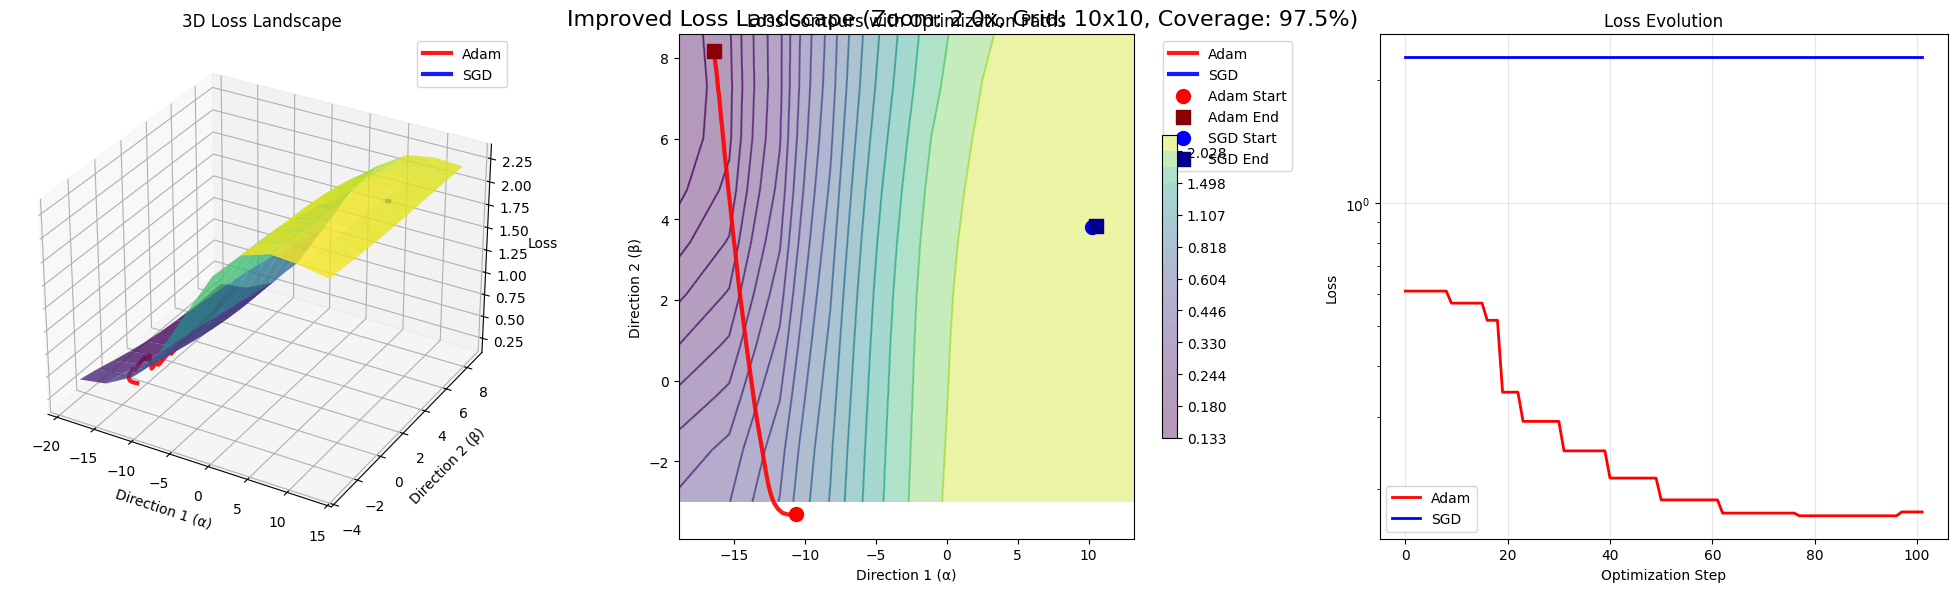


Improved Landscape Statistics:
  Loss range: 0.132988 to 2.359294
  Grid resolution: 10x10
  Zoom factor: 2.0x
  Average coverage: 97.5%
Visualization complete!


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
import copy
from tqdm.auto import tqdm

class TrajectoryCapture:
    """Helper class to capture optimization trajectories"""
    
    def __init__(self, model, save_frequency=5):
        self.trajectory = []
        self.save_frequency = save_frequency
        self.step_count = 0
        
    def capture_weights(self, model):
        """Capture current model weights"""
        if self.step_count % self.save_frequency == 0:
            weight_dict = {}
            for name, param in model.named_parameters():
                weight_dict[name] = param.data.clone()
            self.trajectory.append(weight_dict)
        self.step_count += 1
    
    def get_trajectory(self):
        return self.trajectory

class ImprovedLossLandscapeVisualizer:
    def __init__(self, model_class, model_args, device='cuda'):
        self.model_class = model_class
        self.model_args = model_args
        self.device = device
        
    def setup_data_loaders(self, batch_size=512):
        """Setup MNIST data loaders"""
        print("Setting up data loaders...")
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        trainset = torchvision.datasets.MNIST(
            root='./data', train=True, download=True, transform=transform
        )
        self.train_loader = DataLoader(
            trainset, batch_size=batch_size, shuffle=True, num_workers=2
        )
        
        testset = torchvision.datasets.MNIST(
            root='./data', train=False, download=True, transform=transform
        )
        self.val_loader = DataLoader(
            testset, batch_size=batch_size, shuffle=False, num_workers=2
        )
        
        print(f"Data loaders setup: {len(self.train_loader)} train batches, {len(self.val_loader)} val batches")
        return self.train_loader, self.val_loader
    
    def train_with_trajectory(self, optimizer_type='adam', epochs=20, lr=0.001, 
                            momentum=0.9, capture_frequency=5):
        """Train model and capture optimization trajectory"""
        
        # Create fresh model
        model = self.model_class(**self.model_args).to(self.device)
        
        # Setup optimizer
        if optimizer_type.lower() == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
            print(f"Training with Adam optimizer (lr={lr})")
        elif optimizer_type.lower() == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            print(f"Training with SGD optimizer (lr={lr}, momentum={momentum})")
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_type}")
        
        # Setup trajectory capture
        trajectory_capture = TrajectoryCapture(model, save_frequency=capture_frequency)
        
        # Loss function (NLL loss since model outputs log_softmax)
        criterion = nn.NLLLoss()
        
        # Training loop
        model.train()
        epoch_losses = []
        
        # Progress bar for epochs
        epoch_pbar = tqdm(range(epochs), desc=f"Training ({optimizer_type.upper()})", unit="epoch")
        
        for epoch in epoch_pbar:
            running_loss = 0.0
            num_batches = 0
            
            # Progress bar for batches within each epoch
            batch_pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}", 
                            leave=False, unit="batch")
            
            for batch_idx, (data, target) in enumerate(batch_pbar):
                data, target = data.to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                num_batches += 1
                
                # Update batch progress bar
                batch_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                
                # Capture trajectory
                trajectory_capture.capture_weights(model)
                
                # Early stopping for demo (remove for full training)
                if batch_idx >= 50:  # Only train on subset for faster demo
                    break
            
            avg_loss = running_loss / num_batches
            epoch_losses.append(avg_loss)
            
            # Update epoch progress bar
            epoch_pbar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})
        
        print(f"Training completed! Final loss: {avg_loss:.4f}")
        print(f"Captured {len(trajectory_capture.get_trajectory())} trajectory points")
        
        return model, trajectory_capture.get_trajectory(), epoch_losses
    
    def compare_optimizers_and_visualize(self, epochs=20, lr=0.001, zoom_factor=2.0, grid_size=50):
        """Train two models with different optimizers and create visualization"""
        
        print("="*80)
        print("TRAINING ADAM MODEL")
        print("="*80)
        
        # Get same initial weights for fair comparison
        initial_model = self.model_class(**self.model_args).to(self.device)
        initial_weights = {name: param.clone() for name, param in initial_model.named_parameters()}
        
        # Train with Adam
        adam_model, adam_trajectory, adam_losses = self.train_with_trajectory(
            optimizer_type='adam', epochs=epochs, lr=lr
        )
        
        print("\n" + "="*80)
        print("TRAINING SGD MODEL")
        print("="*80)
        
        # Train with SGD using same initial weights
        sgd_model, sgd_trajectory, sgd_losses = self.train_with_trajectory(
            optimizer_type='sgd', epochs=epochs, lr=lr*10, momentum=0.0
        )
        
        # Set SGD model to same initial weights for fair comparison
        with torch.no_grad():
            for name, param in sgd_model.named_parameters():
                param.copy_(initial_weights[name])
        
        # Retrain SGD with same initial weights
        print("Retraining SGD with same initial weights as Adam...")
        sgd_model, sgd_trajectory, sgd_losses = self.train_with_trajectory(
            optimizer_type='sgd', epochs=epochs, lr=lr*10, momentum=0.0
        )
        
        print("\n" + "="*80)
        print("CREATING VISUALIZATION")
        print("="*80)
        
        # Create visualization
        surface, grids, directions = self.create_better_landscape(
            adam_trajectory, sgd_trajectory, zoom_factor, grid_size
        )
        
        return {
            'adam_model': adam_model,
            'sgd_model': sgd_model,
            'adam_trajectory': adam_trajectory,
            'sgd_trajectory': sgd_trajectory,
            'adam_losses': adam_losses,
            'sgd_losses': sgd_losses,
            'surface': surface,
            'grids': grids,
            'directions': directions
        }
    
    def create_better_landscape(self, main_trajectory, reference_trajectory, 
                              zoom_factor=2.0, grid_size=50, smooth_sigma=0.8):
        """Create an improved loss landscape visualization"""
        
        print(f"Creating improved loss landscape with {zoom_factor}x zoom...")
        
        # Combine all trajectory points
        all_points = main_trajectory + reference_trajectory
        print(f"Total trajectory points: {len(all_points)}")
        
        # Use PCA for better direction finding
        print("Computing PCA directions...")
        directions = self._get_pca_directions(all_points)
        
        # Project trajectories
        print("Projecting trajectories...")
        main_projected = self._project_trajectory(main_trajectory, directions)
        ref_projected = self._project_trajectory(reference_trajectory, directions)
        all_projected = np.vstack([main_projected, ref_projected])
        
        # Calculate adaptive ranges with better coverage
        alpha_range, beta_range = self._calculate_adaptive_ranges(
            all_projected, coverage_target=0.85, zoom_factor=zoom_factor
        )
        
        print(f"Alpha range: [{alpha_range[0]:.6f}, {alpha_range[1]:.6f}]")
        print(f"Beta range: [{beta_range[0]:.6f}, {beta_range[1]:.6f}]")
        
        # Create higher resolution grid
        alpha_grid = np.linspace(alpha_range[0], alpha_range[1], grid_size)
        beta_grid = np.linspace(beta_range[0], beta_range[1], grid_size)
        
        # Use one of the models for loss evaluation
        eval_model = self.model_class(**self.model_args).to(self.device)
        
        # Evaluate loss surface with better interpolation
        loss_surface = self._evaluate_loss_surface_smooth(
            eval_model, alpha_grid, beta_grid, directions, all_points[0], smooth_sigma
        )
        
        # Create visualization
        print("Creating plots...")
        self._create_improved_plot(
            alpha_grid, beta_grid, loss_surface,
            main_projected, ref_projected,
            zoom_factor, grid_size
        )
        
        return loss_surface, (alpha_grid, beta_grid), directions
    
    def _get_pca_directions(self, trajectory_points):
        """Use PCA to find the best 2D projection directions"""
        
        # Flatten all parameter vectors
        param_vectors = []
        print("Flattening parameter vectors...")
        for point in tqdm(trajectory_points, desc="Processing trajectory points", leave=False):
            params = []
            for name in sorted(point.keys()):  # Ensure consistent ordering
                params.extend(point[name].flatten().cpu().numpy())
            param_vectors.append(params)
        
        param_vectors = np.array(param_vectors)
        print(f"Parameter vectors shape: {param_vectors.shape}")
        
        # Apply PCA
        print("Applying PCA...")
        pca = PCA(n_components=2)
        pca.fit(param_vectors)
        
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
        
        # Convert back to parameter structure
        print("Converting PCA components back to parameter structure...")
        directions = []
        param_names = sorted(trajectory_points[0].keys())
        
        for i in range(2):
            direction = {}
            start_idx = 0
            
            for name in param_names:
                param_shape = trajectory_points[0][name].shape
                param_size = trajectory_points[0][name].numel()
                
                direction[name] = torch.tensor(
                    pca.components_[i][start_idx:start_idx + param_size].reshape(param_shape)
                ).to(self.device)
                start_idx += param_size
            
            directions.append(direction)
        
        return directions
    
    def _project_trajectory(self, trajectory, directions):
        """Project trajectory onto the 2D plane"""
        projected = []
        
        for point in tqdm(trajectory, desc="Projecting trajectory", leave=False):
            alpha = sum((point[name] * directions[0][name]).sum().item() 
                       for name in point.keys())
            beta = sum((point[name] * directions[1][name]).sum().item() 
                      for name in point.keys())
            projected.append([alpha, beta])
        
        return np.array(projected)
    
    def _calculate_adaptive_ranges(self, projected_points, coverage_target=0.85, zoom_factor=2.0):
        """Calculate ranges that capture target percentage of points"""
        
        alphas = projected_points[:, 0]
        betas = projected_points[:, 1]
        
        # Calculate percentiles for better coverage
        alpha_p5, alpha_p95 = np.percentile(alphas, [5, 95])
        beta_p5, beta_p95 = np.percentile(betas, [5, 95])
        
        # Add some padding
        alpha_span = alpha_p95 - alpha_p5
        beta_span = beta_p95 - beta_p5
        
        alpha_padding = alpha_span * 0.2 / zoom_factor
        beta_padding = beta_span * 0.2 / zoom_factor
        
        alpha_range = [alpha_p5 - alpha_padding, alpha_p95 + alpha_padding]
        beta_range = [beta_p5 - beta_padding, beta_p95 + beta_padding]
        
        # Verify coverage
        alpha_coverage = np.sum((alphas >= alpha_range[0]) & (alphas <= alpha_range[1])) / len(alphas)
        beta_coverage = np.sum((betas >= beta_range[0]) & (betas <= beta_range[1])) / len(betas)
        
        print(f"Coverage: Alpha {alpha_coverage:.1%}, Beta {beta_coverage:.1%}")
        
        return alpha_range, beta_range
    
    def _evaluate_loss_surface_smooth(self, model, alpha_grid, beta_grid, directions, reference_point, smooth_sigma):
        """Evaluate loss surface with smoothing for better visualization"""
        print(f"Evaluating loss surface on {len(alpha_grid)}x{len(beta_grid)} grid...")
        
        loss_surface = np.zeros((len(beta_grid), len(alpha_grid)))
        criterion = nn.CrossEntropyLoss()
        
        # Create progress bar for grid evaluation
        total_points = len(beta_grid) * len(alpha_grid)
        pbar = tqdm(total=total_points, desc="Evaluating loss surface", unit="point")
        
        for i, beta in enumerate(beta_grid):
            for j, alpha in enumerate(alpha_grid):
                # Set parameters
                with torch.no_grad():
                    for name, param in model.named_parameters():
                        param.copy_(
                            reference_point[name] + 
                            alpha * directions[0][name] + 
                            beta * directions[1][name]
                        )
                
                # Evaluate loss on subset of validation data
                model.eval()
                total_loss = 0
                num_batches = 0
                
                with torch.no_grad():
                    for batch_idx, (data, target) in enumerate(self.val_loader):
                        if batch_idx >= 5:  # Use only first 5 batches for speed
                            break
                        
                        data, target = data.to(self.device), target.to(self.device)
                        output = model(data)
                        loss = criterion(output, target)
                        total_loss += loss.item()
                        num_batches += 1
                
                loss_surface[i, j] = total_loss / num_batches if num_batches > 0 else float('inf')
                
                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({'Current Loss': f'{loss_surface[i, j]:.4f}'})
        
        pbar.close()
        
        # Apply Gaussian smoothing for better visualization
        if smooth_sigma > 0:
            print("Applying Gaussian smoothing...")
            loss_surface = gaussian_filter(loss_surface, sigma=smooth_sigma)
        
        return loss_surface
    
    def _create_improved_plot(self, alpha_grid, beta_grid, loss_surface, 
                            main_projected, ref_projected, zoom_factor, grid_size):
        """Create the improved visualization"""
        
        print("Generating plots...")
        fig = plt.figure(figsize=(20, 6))
        
        # 3D Surface Plot
        ax1 = fig.add_subplot(131, projection='3d')
        X, Y = np.meshgrid(alpha_grid, beta_grid)
        
        # Use better colormap and surface rendering
        surf = ax1.plot_surface(X, Y, loss_surface, 
                              cmap='viridis', alpha=0.8, 
                              linewidth=0, antialiased=True)
        
        # Add trajectory lines in 3D
        main_losses = [self._get_loss_at_point(alpha, beta, alpha_grid, beta_grid, loss_surface) 
                      for alpha, beta in main_projected]
        ref_losses = [self._get_loss_at_point(alpha, beta, alpha_grid, beta_grid, loss_surface) 
                     for alpha, beta in ref_projected]
        
        ax1.plot(main_projected[:, 0], main_projected[:, 1], main_losses, 
                'r-', linewidth=3, label='Adam', alpha=0.9)
        ax1.plot(ref_projected[:, 0], ref_projected[:, 1], ref_losses, 
                'b-', linewidth=3, label='SGD', alpha=0.9)
        
        ax1.set_xlabel('Direction 1 (α)')
        ax1.set_ylabel('Direction 2 (β)')
        ax1.set_zlabel('Loss')
        ax1.set_title('3D Loss Landscape')
        ax1.legend()
        
        # 2D Contour Plot with better levels
        ax2 = fig.add_subplot(132)
        
        # Create better contour levels
        loss_min, loss_max = loss_surface.min(), loss_surface.max()
        levels = np.logspace(np.log10(max(loss_min, 1e-6)), np.log10(loss_max), 20)
        
        contour = ax2.contour(X, Y, loss_surface, levels=levels, alpha=0.6)
        contourf = ax2.contourf(X, Y, loss_surface, levels=levels, cmap='viridis', alpha=0.4)
        
        # Plot trajectories with better styling
        ax2.plot(main_projected[:, 0], main_projected[:, 1], 
                'r-', linewidth=3, label='Adam', alpha=0.9)
        ax2.plot(ref_projected[:, 0], ref_projected[:, 1], 
                'b-', linewidth=3, label='SGD', alpha=0.9)
        
        # Mark start and end points
        ax2.scatter(main_projected[0, 0], main_projected[0, 1], 
                   c='red', s=100, marker='o', label='Adam Start', zorder=5)
        ax2.scatter(main_projected[-1, 0], main_projected[-1, 1], 
                   c='darkred', s=100, marker='s', label='Adam End', zorder=5)
        ax2.scatter(ref_projected[0, 0], ref_projected[0, 1], 
                   c='blue', s=100, marker='o', label='SGD Start', zorder=5)
        ax2.scatter(ref_projected[-1, 0], ref_projected[-1, 1], 
                   c='darkblue', s=100, marker='s', label='SGD End', zorder=5)
        
        ax2.set_xlabel('Direction 1 (α)')
        ax2.set_ylabel('Direction 2 (β)')
        ax2.set_title('Loss Contours with Optimization Paths')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.colorbar(contourf, ax=ax2, shrink=0.6)
        
        # Loss evolution plot
        ax3 = fig.add_subplot(133)
        ax3.plot(range(len(main_losses)), main_losses, 'r-', linewidth=2, label='Adam')
        ax3.plot(range(len(ref_losses)), ref_losses, 'b-', linewidth=2, label='SGD')
        ax3.set_xlabel('Optimization Step')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss Evolution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_yscale('log')
        
        plt.tight_layout()
        
        # Add overall title
        coverage_alpha = np.sum((main_projected[:, 0] >= alpha_grid[0]) & 
                               (main_projected[:, 0] <= alpha_grid[-1])) / len(main_projected)
        coverage_beta = np.sum((main_projected[:, 1] >= beta_grid[0]) & 
                              (main_projected[:, 1] <= beta_grid[-1])) / len(main_projected)
        avg_coverage = (coverage_alpha + coverage_beta) / 2
        
        fig.suptitle(f'Improved Loss Landscape (Zoom: {zoom_factor}x, Grid: {grid_size}x{grid_size}, Coverage: {avg_coverage:.1%})', 
                    fontsize=16, y=0.98)
        
        plt.show()
        
        # Print statistics
        print(f"\nImproved Landscape Statistics:")
        print(f"  Loss range: {loss_surface.min():.6f} to {loss_surface.max():.6f}")
        print(f"  Grid resolution: {grid_size}x{grid_size}")
        print(f"  Zoom factor: {zoom_factor}x")
        print(f"  Average coverage: {avg_coverage:.1%}")
    
    def _get_loss_at_point(self, alpha, beta, alpha_grid, beta_grid, loss_surface):
        """Interpolate loss value at a specific point"""
        # Find nearest grid points
        alpha_idx = np.argmin(np.abs(alpha_grid - alpha))
        beta_idx = np.argmin(np.abs(beta_grid - beta))
        
        # Clamp to grid bounds
        alpha_idx = max(0, min(len(alpha_grid) - 1, alpha_idx))
        beta_idx = max(0, min(len(beta_grid) - 1, beta_idx))
        
        return loss_surface[beta_idx, alpha_idx]

# MNISTNet model for MNIST dataset
class MNISTNet(nn.Module):
    """Simple MLP for MNIST - matching original architecture"""
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Usage example:
if __name__ == "__main__":
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create visualizer
    visualizer = ImprovedLossLandscapeVisualizer(
        model_class=MNISTNet,
        model_args={},  # No arguments needed for MNISTNet
        device=device
    )
    
    # Setup data loaders
    train_loader, val_loader = visualizer.setup_data_loaders(batch_size=512)
    
    # Run comparison and create visualization
    results = visualizer.compare_optimizers_and_visualize(
        epochs=10,          # Reduced for faster demo
        lr=0.001,
        zoom_factor=2.0,    # Conservative zoom
        grid_size=10        # Reasonable resolution
    )
    
    print("Visualization complete!")

Using device: cuda
Loading MNIST data...

Training with SGD...


SGD Training:   2%|▏         | 1/50 [00:13<11:13, 13.74s/it, Loss=0.7203, Acc=77.67%, GradNorm=1.0329]

SGD - Epoch 0: Loss=0.7203, Acc=77.67%, GradNorm=1.0329


SGD Training:  22%|██▏       | 11/50 [02:29<08:51, 13.64s/it, Loss=0.0371, Acc=98.89%, GradNorm=0.9899]

SGD - Epoch 10: Loss=0.0371, Acc=98.89%, GradNorm=0.9899


SGD Training:  42%|████▏     | 21/50 [04:46<06:28, 13.41s/it, Loss=0.0088, Acc=99.83%, GradNorm=0.2457]

SGD - Epoch 20: Loss=0.0088, Acc=99.83%, GradNorm=0.2457


SGD Training:  62%|██████▏   | 31/50 [07:04<04:20, 13.71s/it, Loss=0.0016, Acc=100.00%, GradNorm=0.3967]

SGD - Epoch 30: Loss=0.0016, Acc=100.00%, GradNorm=0.3967


SGD Training:  82%|████████▏ | 41/50 [09:22<02:03, 13.75s/it, Loss=0.0007, Acc=100.00%, GradNorm=0.0229]

SGD - Epoch 40: Loss=0.0007, Acc=100.00%, GradNorm=0.0229


SGD Training: 100%|██████████| 50/50 [11:28<00:00, 13.77s/it, Loss=0.0005, Acc=100.00%, GradNorm=0.0360]


SGD - Final Test Loss: 0.1034, Test Accuracy: 98.02%

Training with SGD_Momentum...


SGD_Momentum Training:   2%|▏         | 1/50 [00:13<10:59, 13.45s/it, Loss=0.4335, Acc=87.26%, GradNorm=1.3966]

SGD_Momentum - Epoch 0: Loss=0.4335, Acc=87.26%, GradNorm=1.3966


SGD_Momentum Training:  22%|██▏       | 11/50 [02:32<09:05, 13.99s/it, Loss=0.0206, Acc=99.33%, GradNorm=0.0673]

SGD_Momentum - Epoch 10: Loss=0.0206, Acc=99.33%, GradNorm=0.0673


SGD_Momentum Training:  42%|████▏     | 21/50 [04:49<06:35, 13.64s/it, Loss=0.0103, Acc=99.65%, GradNorm=0.0010]

SGD_Momentum - Epoch 20: Loss=0.0103, Acc=99.65%, GradNorm=0.0010


SGD_Momentum Training:  62%|██████▏   | 31/50 [07:06<04:20, 13.72s/it, Loss=0.0089, Acc=99.72%, GradNorm=0.0416]

SGD_Momentum - Epoch 30: Loss=0.0089, Acc=99.72%, GradNorm=0.0416


SGD_Momentum Training:  82%|████████▏ | 41/50 [09:24<02:04, 13.84s/it, Loss=0.0069, Acc=99.79%, GradNorm=0.2036]

SGD_Momentum - Epoch 40: Loss=0.0069, Acc=99.79%, GradNorm=0.2036


SGD_Momentum Training: 100%|██████████| 50/50 [11:30<00:00, 13.81s/it, Loss=0.0000, Acc=100.00%, GradNorm=0.0003]


SGD_Momentum - Final Test Loss: 0.1308, Test Accuracy: 98.16%

Training with Adam...


Adam Training:   2%|▏         | 1/50 [00:13<11:17, 13.82s/it, Loss=0.3999, Acc=88.71%, GradNorm=1.0765]

Adam - Epoch 0: Loss=0.3999, Acc=88.71%, GradNorm=1.0765


Adam Training:  22%|██▏       | 11/50 [02:33<09:03, 13.93s/it, Loss=0.0217, Acc=99.28%, GradNorm=0.6643]

Adam - Epoch 10: Loss=0.0217, Acc=99.28%, GradNorm=0.6643


Adam Training:  42%|████▏     | 21/50 [04:52<06:34, 13.61s/it, Loss=0.0134, Acc=99.55%, GradNorm=1.0211]

Adam - Epoch 20: Loss=0.0134, Acc=99.55%, GradNorm=1.0211


Adam Training:  62%|██████▏   | 31/50 [07:06<04:15, 13.46s/it, Loss=0.0088, Acc=99.70%, GradNorm=0.0056]

Adam - Epoch 30: Loss=0.0088, Acc=99.70%, GradNorm=0.0056


Adam Training:  82%|████████▏ | 41/50 [09:22<02:01, 13.53s/it, Loss=0.0035, Acc=99.87%, GradNorm=0.3373]

Adam - Epoch 40: Loss=0.0035, Acc=99.87%, GradNorm=0.3373


Adam Training: 100%|██████████| 50/50 [11:19<00:00, 13.60s/it, Loss=0.0000, Acc=100.00%, GradNorm=0.0028]


Adam - Final Test Loss: 0.1110, Test Accuracy: 98.40%

COMPUTING ADVANCED METRICS

Computing Sharpness/Flatness...


SGD Sharpness: 0.000000


SGD_Momentum Sharpness: 0.000018


Adam Sharpness: 0.000000

Computing Loss Barriers...


Loss Barrier SGD <-> SGD_Momentum: 1.3260


Loss Barrier SGD <-> Adam: 1.6061


Loss Barrier SGD_Momentum <-> Adam: 1.1904

Computing Local Curvature...
SGD - Avg Curvature: 0.000000, Max Curvature: 0.000000
SGD_Momentum - Avg Curvature: 0.000000, Max Curvature: 0.000000
Adam - Avg Curvature: 0.000000, Max Curvature: 0.000000

Analyzing Convergence Speed...
Time to reach loss thresholds (seconds):

SGD:
  Loss 2.0: 13.74s
  Loss 1.5: 13.74s
  Loss 1.0: 13.74s
  Loss 0.5: 27.40s
  Loss 0.1: 68.21s

SGD_Momentum:
  Loss 2.0: 13.45s
  Loss 1.5: 13.45s
  Loss 1.0: 13.45s
  Loss 0.5: 13.45s
  Loss 0.1: 40.47s

Adam:
  Loss 2.0: 13.82s
  Loss 1.5: 13.82s
  Loss 1.0: 13.82s
  Loss 0.5: 13.82s
  Loss 0.1: 55.85s


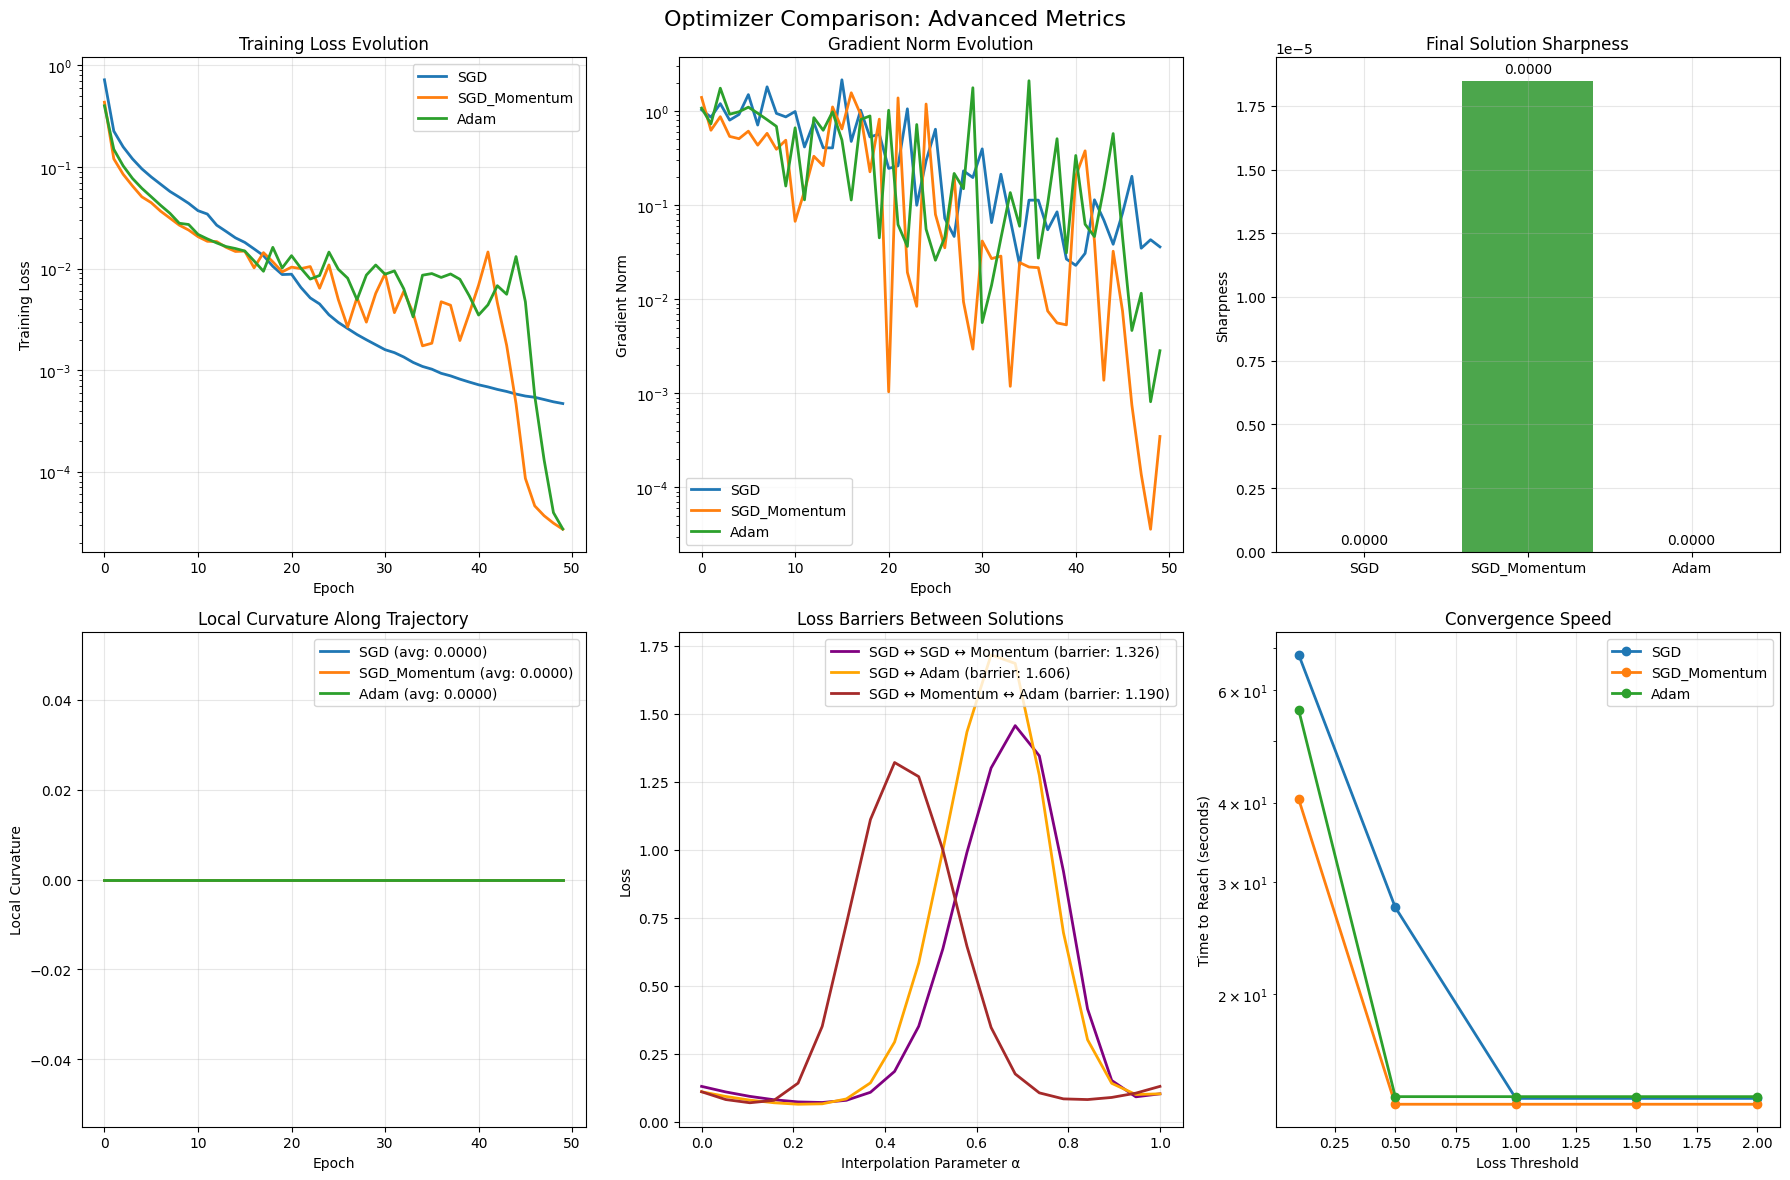


SUMMARY COMPARISON

Optimizer       Test Loss    Test Acc     Sharpness    Avg Curv    
----------------------------------------------------------------------
SGD             0.1034       98.02        0.000000     0.000000    
SGD_Momentum    0.1308       98.16        0.000018     0.000000    
Adam            0.1110       98.40        0.000000     0.000000    

Loss Barriers:
  SGD ↔ SGD ↔ Momentum: 1.3260
  SGD ↔ Adam: 1.6061
  SGD ↔ Momentum ↔ Adam: 1.1904


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import time
from collections import defaultdict
import copy
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class MLP(nn.Module):
    """4 hidden layer MLP: 784->128->128->128->128->10"""
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.layers(x)

def load_mnist_data(batch_size=256):
    """Load MNIST data with specified batch size"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def compute_sharpness(model, data_loader, num_samples=10, epsilon=0.01):
    """Compute sharpness using finite differences approximation"""
    model.eval()
    original_loss = 0.0
    perturbed_losses = []
    
    # Compute original loss
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc="Computing original loss", leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            original_loss += F.cross_entropy(output, target, reduction='sum').item()
    original_loss /= len(data_loader.dataset)
    
    # Compute perturbed losses
    original_params = []
    for param in model.parameters():
        original_params.append(param.data.clone())
    
    for sample_idx in tqdm(range(num_samples), desc="Computing sharpness", leave=False):
        # Apply random perturbation
        with torch.no_grad():
            for param in model.parameters():
                noise = torch.randn_like(param) 
                param.data += epsilon * noise / torch.norm(noise)
        
        # Compute loss with perturbation
        perturbed_loss = 0.0
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                perturbed_loss += F.cross_entropy(output, target, reduction='sum').item()
        perturbed_loss /= len(data_loader.dataset)
        perturbed_losses.append(perturbed_loss)
        
        # Restore original params
        for param, original in zip(model.parameters(), original_params):
            param.data.copy_(original)
    
    # Estimate sharpness as average perturbation effect
    sharpness = np.mean([(loss - original_loss) for loss in perturbed_losses])
    return max(0, sharpness)  # Ensure non-negative

def compute_loss_barrier(model1, model2, data_loader, num_points=20):
    """Compute loss barrier between two models via linear interpolation"""
    # Get parameters
    params1 = [p.data.clone() for p in model1.parameters()]
    params2 = [p.data.clone() for p in model2.parameters()]
    
    losses = []
    alphas = np.linspace(0, 1, num_points)
    
    for alpha in tqdm(alphas, desc="Computing loss barrier", leave=False):
        # Interpolate parameters
        with torch.no_grad():
            for param, p1, p2 in zip(model1.parameters(), params1, params2):
                param.data.copy_(alpha * p1 + (1 - alpha) * p2)
        
        # Compute loss
        model1.eval()
        total_loss = 0.0
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(device), target.to(device)
                output = model1(data)
                total_loss += F.cross_entropy(output, target, reduction='sum').item()
        losses.append(total_loss / len(data_loader.dataset))
    
    # Restore model1 parameters
    with torch.no_grad():
        for param, p1 in zip(model1.parameters(), params1):
            param.data.copy_(p1)
    
    # Calculate barrier height
    end_losses = [losses[0], losses[-1]]
    max_loss = max(losses)
    barrier_height = max_loss - max(end_losses)
    
    return barrier_height, losses, alphas

def compute_local_curvature(loss_history, window=5):
    """Compute local curvature along trajectory"""
    if len(loss_history) < window:
        return [0] * len(loss_history)
    
    curvatures = []
    for i in range(len(loss_history)):
        if i < window//2 or i >= len(loss_history) - window//2:
            curvatures.append(0)
        else:
            # Fit quadratic to local window
            x = np.arange(-window//2, window//2 + 1)
            y = loss_history[i-window//2:i+window//2+1]
            
            # Quadratic fit: y = ax² + bx + c
            # Second derivative is 2a
            A = np.vstack([x**2, x, np.ones(len(x))]).T
            try:
                coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
                curvature = 2 * abs(coeffs[0])  # |2a|
            except:
                curvature = 0
            curvatures.append(curvature)
    
    return curvatures

class MetricTracker:
    """Track various metrics during training"""
    def __init__(self):
        self.metrics = defaultdict(list)
        self.convergence_thresholds = [2.0, 1.5, 1.0, 0.5, 0.1]
        self.convergence_times = {thresh: None for thresh in self.convergence_thresholds}
    
    def update(self, epoch, loss, accuracy, gradient_norm, param_norm, start_time):
        self.metrics['epoch'].append(epoch)
        self.metrics['loss'].append(loss)
        self.metrics['accuracy'].append(accuracy)
        self.metrics['gradient_norm'].append(gradient_norm)
        self.metrics['param_norm'].append(param_norm)
        self.metrics['time'].append(time.time() - start_time)
        
        # Check convergence thresholds
        for thresh in self.convergence_thresholds:
            if self.convergence_times[thresh] is None and loss <= thresh:
                self.convergence_times[thresh] = time.time() - start_time

def train_optimizer(optimizer_name, model, train_loader, test_loader, epochs=50, lr=0.001):
    """Train model with specified optimizer and track metrics"""
    print(f"\nTraining with {optimizer_name}...")
    
    # Initialize optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr*100)
    elif optimizer_name == "SGD_Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr*100, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    tracker = MetricTracker()
    start_time = time.time()
    
    # Main training loop with tqdm
    epoch_pbar = tqdm(range(epochs), desc=f"{optimizer_name} Training", position=0)
    
    for epoch in epoch_pbar:
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Batch loop with tqdm
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", 
                         position=1, leave=False)
        
        for batch_idx, (data, target) in enumerate(batch_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            # Update batch progress bar
            batch_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        # Calculate metrics
        avg_loss = train_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        # Gradient norm
        grad_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2
        grad_norm = grad_norm ** 0.5
        
        # Parameter norm
        param_norm = 0.0
        for param in model.parameters():
            param_norm += param.data.norm(2).item() ** 2
        param_norm = param_norm ** 0.5
        
        # Update tracker
        tracker.update(epoch, avg_loss, accuracy, grad_norm, param_norm, start_time)
        
        # Update epoch progress bar
        epoch_pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Acc': f'{accuracy:.2f}%',
            'GradNorm': f'{grad_norm:.4f}'
        })
        
        if epoch % 10 == 0:
            tqdm.write(f'{optimizer_name} - Epoch {epoch}: Loss={avg_loss:.4f}, Acc={accuracy:.2f}%, GradNorm={grad_norm:.4f}')
    
    # Final evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    
    test_pbar = tqdm(test_loader, desc=f"{optimizer_name} Final Evaluation", leave=False)
    with torch.no_grad():
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    
    print(f'{optimizer_name} - Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    
    return model, tracker, test_loss, test_acc

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Load data
    print("Loading MNIST data...")
    train_loader, test_loader = load_mnist_data(batch_size=256)
    
    # Initialize models
    models = {}
    trackers = {}
    test_results = {}
    
    optimizers = ["SGD", "SGD_Momentum", "Adam"]
    
    # Train each optimizer
    for opt_name in optimizers:
        model = MLP().to(device)
        model, tracker, test_loss, test_acc = train_optimizer(
            opt_name, model, train_loader, test_loader, epochs=50, lr=0.001
        )
        models[opt_name] = model
        trackers[opt_name] = tracker
        test_results[opt_name] = (test_loss, test_acc)
    
    print("\n" + "="*50)
    print("COMPUTING ADVANCED METRICS")
    print("="*50)
    
    # Compute Sharpness/Flatness
    print("\nComputing Sharpness/Flatness...")
    sharpness_results = {}
    for opt_name, model in models.items():
        sharpness = compute_sharpness(model, test_loader, num_samples=5)
        sharpness_results[opt_name] = sharpness
        print(f"{opt_name} Sharpness: {sharpness:.6f}")
    
    # Compute Loss Barriers between optimizers
    print("\nComputing Loss Barriers...")
    barrier_results = {}
    opt_pairs = [("SGD", "SGD_Momentum"), ("SGD", "Adam"), ("SGD_Momentum", "Adam")]
    
    for opt1, opt2 in opt_pairs:
        barrier_height, losses, alphas = compute_loss_barrier(
            models[opt1], models[opt2], test_loader
        )
        barrier_results[f"{opt1}_{opt2}"] = {
            'height': barrier_height,
            'losses': losses,
            'alphas': alphas
        }
        print(f"Loss Barrier {opt1} <-> {opt2}: {barrier_height:.4f}")
    
    # Compute Local Curvature
    print("\nComputing Local Curvature...")
    curvature_results = {}
    for opt_name, tracker in trackers.items():
        curvatures = compute_local_curvature(tracker.metrics['loss'])
        avg_curvature = np.mean(curvatures)
        max_curvature = np.max(curvatures)
        curvature_results[opt_name] = {
            'curvatures': curvatures,
            'avg': avg_curvature,
            'max': max_curvature
        }
        print(f"{opt_name} - Avg Curvature: {avg_curvature:.6f}, Max Curvature: {max_curvature:.6f}")
    
    # Analyze Convergence Speed
    print("\nAnalyzing Convergence Speed...")
    print("Time to reach loss thresholds (seconds):")
    for opt_name, tracker in trackers.items():
        print(f"\n{opt_name}:")
        for thresh, time_val in tracker.convergence_times.items():
            if time_val is not None:
                print(f"  Loss {thresh}: {time_val:.2f}s")
            else:
                print(f"  Loss {thresh}: Not reached")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Optimizer Comparison: Advanced Metrics', fontsize=16)
    
    # Plot 1: Training Loss
    ax = axes[0, 0]
    for opt_name, tracker in trackers.items():
        ax.plot(tracker.metrics['epoch'], tracker.metrics['loss'], label=opt_name, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Loss Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Plot 2: Gradient Norm
    ax = axes[0, 1]
    for opt_name, tracker in trackers.items():
        ax.plot(tracker.metrics['epoch'], tracker.metrics['gradient_norm'], label=opt_name, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Gradient Norm Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Plot 3: Sharpness Comparison
    ax = axes[0, 2]
    opt_names = list(sharpness_results.keys())
    sharpness_values = list(sharpness_results.values())
    bars = ax.bar(opt_names, sharpness_values, color=['blue', 'green', 'red'], alpha=0.7)
    ax.set_ylabel('Sharpness')
    ax.set_title('Final Solution Sharpness')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, sharpness_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sharpness_values)*0.01,
                f'{value:.4f}', ha='center', va='bottom')
    
    # Plot 4: Local Curvature
    ax = axes[1, 0]
    for opt_name, result in curvature_results.items():
        ax.plot(trackers[opt_name].metrics['epoch'], result['curvatures'], 
                label=f'{opt_name} (avg: {result["avg"]:.4f})', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Local Curvature')
    ax.set_title('Local Curvature Along Trajectory')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Loss Barriers
    ax = axes[1, 1]
    colors = ['purple', 'orange', 'brown']
    for i, (pair, result) in enumerate(barrier_results.items()):
        ax.plot(result['alphas'], result['losses'], 
                label=f'{pair.replace("_", " ↔ ")} (barrier: {result["height"]:.3f})',
                color=colors[i], linewidth=2)
    ax.set_xlabel('Interpolation Parameter α')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Barriers Between Solutions')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Convergence Speed
    ax = axes[1, 2]
    thresholds = [t for t in trackers['SGD'].convergence_times.keys() if t <= 2.0]  # Focus on achievable thresholds
    
    for opt_name, tracker in trackers.items():
        times = [tracker.convergence_times[t] if tracker.convergence_times[t] is not None else float('inf') 
                for t in thresholds]
        # Replace inf with max time for plotting
        max_time = max([t for t in times if t != float('inf')] + [50])
        times = [t if t != float('inf') else max_time * 1.1 for t in times]
        ax.plot(thresholds, times, 'o-', label=opt_name, linewidth=2, markersize=6)
    
    ax.set_xlabel('Loss Threshold')
    ax.set_ylabel('Time to Reach (seconds)')
    ax.set_title('Convergence Speed')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print Summary
    print("\n" + "="*50)
    print("SUMMARY COMPARISON")
    print("="*50)
    
    print(f"\n{'Optimizer':<15} {'Test Loss':<12} {'Test Acc':<12} {'Sharpness':<12} {'Avg Curv':<12}")
    print("-" * 70)
    for opt_name in optimizers:
        test_loss, test_acc = test_results[opt_name]
        sharpness = sharpness_results[opt_name]
        avg_curv = curvature_results[opt_name]['avg']
        print(f"{opt_name:<15} {test_loss:<12.4f} {test_acc:<12.2f} {sharpness:<12.6f} {avg_curv:<12.6f}")
    
    print(f"\nLoss Barriers:")
    for pair, result in barrier_results.items():
        print(f"  {pair.replace('_', ' ↔ ')}: {result['height']:.4f}")

if __name__ == "__main__":
    main()

Using device: cuda
Loading MNIST data...
Creating initial model and saving weights...
Initial weights saved to initial_weights.pkl

Training SGD
Initial weights loaded from initial_weights.pkl

Training with SGD...


SGD Training:   2%|▏         | 1/50 [00:12<09:48, 12.00s/it, Loss=0.7159, Acc=78.03%, GradNorm=1.3082]

SGD - Epoch 0: Loss=0.7159, Acc=78.03%, GradNorm=1.3082


SGD Training:  22%|██▏       | 11/50 [02:06<07:26, 11.45s/it, Loss=0.0377, Acc=98.86%, GradNorm=0.9924]

SGD - Epoch 10: Loss=0.0377, Acc=98.86%, GradNorm=0.9924


SGD Training:  42%|████▏     | 21/50 [04:00<05:33, 11.51s/it, Loss=0.0183, Acc=99.47%, GradNorm=1.1894]

SGD - Epoch 20: Loss=0.0183, Acc=99.47%, GradNorm=1.1894


SGD Training:  62%|██████▏   | 31/50 [05:57<03:42, 11.72s/it, Loss=0.0021, Acc=99.98%, GradNorm=0.2279]

SGD - Epoch 30: Loss=0.0021, Acc=99.98%, GradNorm=0.2279


SGD Training:  82%|████████▏ | 41/50 [07:56<01:46, 11.81s/it, Loss=0.0008, Acc=100.00%, GradNorm=0.0542]

SGD - Epoch 40: Loss=0.0008, Acc=100.00%, GradNorm=0.0542


SGD Training: 100%|██████████| 50/50 [09:43<00:00, 11.66s/it, Loss=0.0005, Acc=100.00%, GradNorm=0.0319]


SGD - Final Test Loss: 0.1012, Test Accuracy: 98.06%

Training SGD_Momentum
Initial weights loaded from initial_weights.pkl

Training with SGD_Momentum...


SGD_Momentum Training:   2%|▏         | 1/50 [00:11<09:32, 11.68s/it, Loss=0.3956, Acc=88.05%, GradNorm=1.3869]

SGD_Momentum - Epoch 0: Loss=0.3956, Acc=88.05%, GradNorm=1.3869


SGD_Momentum Training:  22%|██▏       | 11/50 [02:08<07:37, 11.74s/it, Loss=0.0197, Acc=99.38%, GradNorm=0.3088]

SGD_Momentum - Epoch 10: Loss=0.0197, Acc=99.38%, GradNorm=0.3088


SGD_Momentum Training:  42%|████▏     | 21/50 [04:07<05:42, 11.80s/it, Loss=0.0122, Acc=99.62%, GradNorm=0.0680]

SGD_Momentum - Epoch 20: Loss=0.0122, Acc=99.62%, GradNorm=0.0680


SGD_Momentum Training:  62%|██████▏   | 31/50 [06:06<03:46, 11.90s/it, Loss=0.0045, Acc=99.86%, GradNorm=0.0005]

SGD_Momentum - Epoch 30: Loss=0.0045, Acc=99.86%, GradNorm=0.0005


SGD_Momentum Training:  82%|████████▏ | 41/50 [08:03<01:45, 11.72s/it, Loss=0.0051, Acc=99.81%, GradNorm=0.0091]

SGD_Momentum - Epoch 40: Loss=0.0051, Acc=99.81%, GradNorm=0.0091


SGD_Momentum Training: 100%|██████████| 50/50 [09:50<00:00, 11.80s/it, Loss=0.0027, Acc=99.91%, GradNorm=0.7440]


SGD_Momentum - Final Test Loss: 0.1209, Test Accuracy: 98.18%

Training Adam
Initial weights loaded from initial_weights.pkl

Training with Adam...


Adam Training:   2%|▏         | 1/50 [00:12<09:49, 12.03s/it, Loss=0.4015, Acc=88.11%, GradNorm=0.9565]

Adam - Epoch 0: Loss=0.4015, Acc=88.11%, GradNorm=0.9565


Adam Training:  22%|██▏       | 11/50 [02:10<07:43, 11.88s/it, Loss=0.0194, Acc=99.36%, GradNorm=1.2905]

Adam - Epoch 10: Loss=0.0194, Acc=99.36%, GradNorm=1.2905


Adam Training:  42%|████▏     | 21/50 [04:09<05:45, 11.90s/it, Loss=0.0135, Acc=99.53%, GradNorm=0.8764]

Adam - Epoch 20: Loss=0.0135, Acc=99.53%, GradNorm=0.8764


Adam Training:  62%|██████▏   | 31/50 [06:09<03:46, 11.90s/it, Loss=0.0036, Acc=99.88%, GradNorm=0.0052]

Adam - Epoch 30: Loss=0.0036, Acc=99.88%, GradNorm=0.0052


Adam Training:  82%|████████▏ | 41/50 [08:10<01:49, 12.20s/it, Loss=0.0020, Acc=99.93%, GradNorm=0.0080]

Adam - Epoch 40: Loss=0.0020, Acc=99.93%, GradNorm=0.0080


Adam Training: 100%|██████████| 50/50 [09:57<00:00, 11.95s/it, Loss=0.0130, Acc=99.59%, GradNorm=0.1770]


Adam - Final Test Loss: 0.1114, Test Accuracy: 98.09%

COMPUTING ADVANCED METRICS

Computing Sharpness/Flatness...


SGD Sharpness: 0.000000


SGD_Momentum Sharpness: 0.000000


Adam Sharpness: 0.000007

Computing Loss Barriers...


Loss Barrier SGD <-> SGD_Momentum: 0.0592


Loss Barrier SGD <-> Adam: 0.0271


Loss Barrier SGD_Momentum <-> Adam: 0.0296

Computing Local Curvature...
SGD - Avg Curvature: 0.000000, Max Curvature: 0.000000
SGD_Momentum - Avg Curvature: 0.000000, Max Curvature: 0.000000
Adam - Avg Curvature: 0.000000, Max Curvature: 0.000000

Analyzing Convergence Speed...
Time to reach loss thresholds (seconds):

SGD:
  Loss 2.0: 12.00s
  Loss 1.5: 12.00s
  Loss 1.0: 12.00s
  Loss 0.5: 23.71s
  Loss 0.1: 58.33s

SGD_Momentum:
  Loss 2.0: 11.68s
  Loss 1.5: 11.68s
  Loss 1.0: 11.68s
  Loss 0.5: 11.68s
  Loss 0.1: 35.20s

Adam:
  Loss 2.0: 12.03s
  Loss 1.5: 12.03s
  Loss 1.0: 12.03s
  Loss 0.5: 12.03s
  Loss 0.1: 47.36s


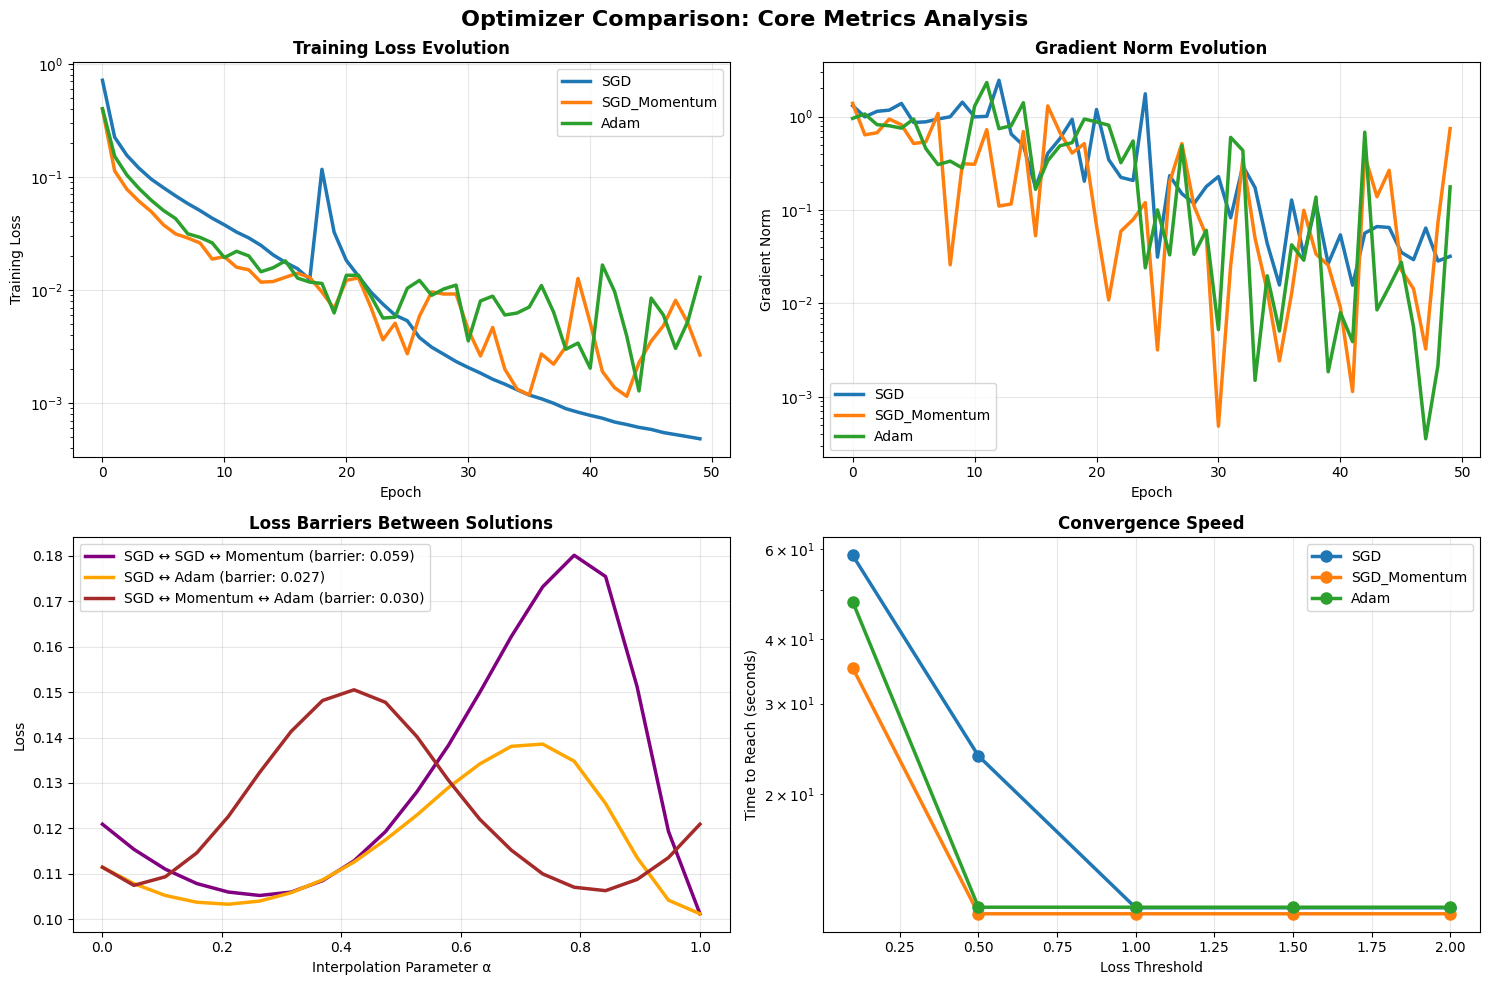


COMPREHENSIVE SUMMARY COMPARISON

=============== PERFORMANCE METRICS ===============
Optimizer       Test Loss    Test Acc     Final Train Loss
------------------------------------------------------------
SGD             0.1012       98.06       % 0.0005         
SGD_Momentum    0.1209       98.18       % 0.0027         
Adam            0.1114       98.09       % 0.0130         

=============== SOLUTION QUALITY METRICS ===============
Optimizer       Sharpness       Avg Curvature   Max Curvature  
----------------------------------------------------------------------
SGD             0.000000        0.000000        0.000000       
SGD_Momentum    0.000000        0.000000        0.000000       
Adam            0.000007        0.000000        0.000000       

=============== LOSS BARRIERS ===============
  SGD ↔ SGD ↔ Momentum: 0.0592
  SGD ↔ Adam          : 0.0271
  SGD ↔ Momentum ↔ Adam: 0.0296

=============== CONVERGENCE ANALYSIS ===============

SGD:
  Loss 2.0 :    12.00s
  Loss 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import time
from collections import defaultdict
import copy
from tqdm import tqdm
import pickle
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class MLP(nn.Module):
    """4 hidden layer MLP: 784->128->128->128->128->10"""
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.layers(x)

def load_mnist_data(batch_size=256):
    """Load MNIST data with specified batch size"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def save_initial_weights(model, filename='initial_weights.pkl'):
    """Save initial model weights"""
    initial_weights = {}
    for name, param in model.named_parameters():
        initial_weights[name] = param.data.clone().cpu()
    
    with open(filename, 'wb') as f:
        pickle.dump(initial_weights, f)
    print(f"Initial weights saved to {filename}")

def load_initial_weights(model, filename='initial_weights.pkl'):
    """Load initial model weights"""
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            initial_weights = pickle.load(f)
        
        for name, param in model.named_parameters():
            param.data.copy_(initial_weights[name].to(device))
        print(f"Initial weights loaded from {filename}")
        return True
    return False

def compute_sharpness(model, data_loader, num_samples=10, epsilon=0.01):
    """Compute sharpness using finite differences approximation"""
    model.eval()
    original_loss = 0.0
    perturbed_losses = []
    
    # Compute original loss
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc="Computing original loss", leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            original_loss += F.cross_entropy(output, target, reduction='sum').item()
    original_loss /= len(data_loader.dataset)
    
    # Compute perturbed losses
    original_params = []
    for param in model.parameters():
        original_params.append(param.data.clone())
    
    for sample_idx in tqdm(range(num_samples), desc="Computing sharpness", leave=False):
        # Apply random perturbation
        with torch.no_grad():
            for param in model.parameters():
                noise = torch.randn_like(param) 
                param.data += epsilon * noise / torch.norm(noise)
        
        # Compute loss with perturbation
        perturbed_loss = 0.0
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                perturbed_loss += F.cross_entropy(output, target, reduction='sum').item()
        perturbed_loss /= len(data_loader.dataset)
        perturbed_losses.append(perturbed_loss)
        
        # Restore original params
        for param, original in zip(model.parameters(), original_params):
            param.data.copy_(original)
    
    # Estimate sharpness as average perturbation effect
    sharpness = np.mean([(loss - original_loss) for loss in perturbed_losses])
    return max(0, sharpness)  # Ensure non-negative

def compute_loss_barrier(model1, model2, data_loader, num_points=20):
    """Compute loss barrier between two models via linear interpolation"""
    # Get parameters
    params1 = [p.data.clone() for p in model1.parameters()]
    params2 = [p.data.clone() for p in model2.parameters()]
    
    losses = []
    alphas = np.linspace(0, 1, num_points)
    
    for alpha in tqdm(alphas, desc="Computing loss barrier", leave=False):
        # Interpolate parameters
        with torch.no_grad():
            for param, p1, p2 in zip(model1.parameters(), params1, params2):
                param.data.copy_(alpha * p1 + (1 - alpha) * p2)
        
        # Compute loss
        model1.eval()
        total_loss = 0.0
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(device), target.to(device)
                output = model1(data)
                total_loss += F.cross_entropy(output, target, reduction='sum').item()
        losses.append(total_loss / len(data_loader.dataset))
    
    # Restore model1 parameters
    with torch.no_grad():
        for param, p1 in zip(model1.parameters(), params1):
            param.data.copy_(p1)
    
    # Calculate barrier height
    end_losses = [losses[0], losses[-1]]
    max_loss = max(losses)
    barrier_height = max_loss - max(end_losses)
    
    return barrier_height, losses, alphas

def compute_local_curvature(loss_history, window=5):
    """Compute local curvature along trajectory"""
    if len(loss_history) < window:
        return [0] * len(loss_history)
    
    curvatures = []
    for i in range(len(loss_history)):
        if i < window//2 or i >= len(loss_history) - window//2:
            curvatures.append(0)
        else:
            # Fit quadratic to local window
            x = np.arange(-window//2, window//2 + 1)
            y = loss_history[i-window//2:i+window//2+1]
            
            # Quadratic fit: y = ax² + bx + c
            # Second derivative is 2a
            A = np.vstack([x**2, x, np.ones(len(x))]).T
            try:
                coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
                curvature = 2 * abs(coeffs[0])  # |2a|
            except:
                curvature = 0
            curvatures.append(curvature)
    
    return curvatures

class MetricTracker:
    """Track various metrics during training"""
    def __init__(self):
        self.metrics = defaultdict(list)
        self.convergence_thresholds = [2.0, 1.5, 1.0, 0.5, 0.1]
        self.convergence_times = {thresh: None for thresh in self.convergence_thresholds}
    
    def update(self, epoch, loss, accuracy, gradient_norm, param_norm, start_time):
        self.metrics['epoch'].append(epoch)
        self.metrics['loss'].append(loss)
        self.metrics['accuracy'].append(accuracy)
        self.metrics['gradient_norm'].append(gradient_norm)
        self.metrics['param_norm'].append(param_norm)
        self.metrics['time'].append(time.time() - start_time)
        
        # Check convergence thresholds
        for thresh in self.convergence_thresholds:
            if self.convergence_times[thresh] is None and loss <= thresh:
                self.convergence_times[thresh] = time.time() - start_time

def train_optimizer(optimizer_name, model, train_loader, test_loader, epochs=50, lr=0.001):
    """Train model with specified optimizer and track metrics"""
    print(f"\nTraining with {optimizer_name}...")
    
    # Initialize optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr*100)
    elif optimizer_name == "SGD_Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr*100, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    tracker = MetricTracker()
    start_time = time.time()
    
    # Main training loop with tqdm
    epoch_pbar = tqdm(range(epochs), desc=f"{optimizer_name} Training", position=0)
    
    for epoch in epoch_pbar:
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Batch loop with tqdm
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", 
                         position=1, leave=False)
        
        for batch_idx, (data, target) in enumerate(batch_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            # Update batch progress bar
            batch_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        # Calculate metrics
        avg_loss = train_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        # Gradient norm
        grad_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2
        grad_norm = grad_norm ** 0.5
        
        # Parameter norm
        param_norm = 0.0
        for param in model.parameters():
            param_norm += param.data.norm(2).item() ** 2
        param_norm = param_norm ** 0.5
        
        # Update tracker
        tracker.update(epoch, avg_loss, accuracy, grad_norm, param_norm, start_time)
        
        # Update epoch progress bar
        epoch_pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Acc': f'{accuracy:.2f}%',
            'GradNorm': f'{grad_norm:.4f}'
        })
        
        if epoch % 10 == 0:
            tqdm.write(f'{optimizer_name} - Epoch {epoch}: Loss={avg_loss:.4f}, Acc={accuracy:.2f}%, GradNorm={grad_norm:.4f}')
    
    # Final evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    
    test_pbar = tqdm(test_loader, desc=f"{optimizer_name} Final Evaluation", leave=False)
    with torch.no_grad():
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    
    print(f'{optimizer_name} - Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    
    return model, tracker, test_loss, test_acc

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    # Load data
    print("Loading MNIST data...")
    train_loader, test_loader = load_mnist_data(batch_size=256)
    
    # Create initial model and save weights to ensure same initialization
    print("Creating initial model and saving weights...")
    initial_model = MLP().to(device)
    save_initial_weights(initial_model, 'initial_weights.pkl')
    
    # Initialize models and results storage
    models = {}
    trackers = {}
    test_results = {}
    
    optimizers = ["SGD", "SGD_Momentum", "Adam"]
    
    # Train each optimizer starting from the SAME initialization
    for opt_name in optimizers:
        print(f"\n{'='*50}")
        print(f"Training {opt_name}")
        print(f"{'='*50}")
        
        # Create model and load same initial weights
        model = MLP().to(device)
        load_initial_weights(model, 'initial_weights.pkl')
        
        # Train the model
        model, tracker, test_loss, test_acc = train_optimizer(
            opt_name, model, train_loader, test_loader, epochs=50, lr=0.001
        )
        
        # Store results
        models[opt_name] = model
        trackers[opt_name] = tracker
        test_results[opt_name] = (test_loss, test_acc)
    
    print("\n" + "="*50)
    print("COMPUTING ADVANCED METRICS")
    print("="*50)
    
    # Compute Sharpness/Flatness
    print("\nComputing Sharpness/Flatness...")
    sharpness_results = {}
    for opt_name, model in models.items():
        sharpness = compute_sharpness(model, test_loader, num_samples=5)
        sharpness_results[opt_name] = sharpness
        print(f"{opt_name} Sharpness: {sharpness:.6f}")
    
    # Compute Loss Barriers between optimizers
    print("\nComputing Loss Barriers...")
    barrier_results = {}
    opt_pairs = [("SGD", "SGD_Momentum"), ("SGD", "Adam"), ("SGD_Momentum", "Adam")]
    
    for opt1, opt2 in opt_pairs:
        barrier_height, losses, alphas = compute_loss_barrier(
            models[opt1], models[opt2], test_loader
        )
        barrier_results[f"{opt1}_{opt2}"] = {
            'height': barrier_height,
            'losses': losses,
            'alphas': alphas
        }
        print(f"Loss Barrier {opt1} <-> {opt2}: {barrier_height:.4f}")
    
    # Compute Local Curvature
    print("\nComputing Local Curvature...")
    curvature_results = {}
    for opt_name, tracker in trackers.items():
        curvatures = compute_local_curvature(tracker.metrics['loss'])
        avg_curvature = np.mean(curvatures)
        max_curvature = np.max(curvatures)
        curvature_results[opt_name] = {
            'curvatures': curvatures,
            'avg': avg_curvature,
            'max': max_curvature
        }
        print(f"{opt_name} - Avg Curvature: {avg_curvature:.6f}, Max Curvature: {max_curvature:.6f}")
    
    # Analyze Convergence Speed
    print("\nAnalyzing Convergence Speed...")
    print("Time to reach loss thresholds (seconds):")
    for opt_name, tracker in trackers.items():
        print(f"\n{opt_name}:")
        for thresh, time_val in tracker.convergence_times.items():
            if time_val is not None:
                print(f"  Loss {thresh}: {time_val:.2f}s")
            else:
                print(f"  Loss {thresh}: Not reached")
    
    # Create 4 plots as requested
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Optimizer Comparison: Core Metrics Analysis', fontsize=16, fontweight='bold')
    
    # Colors for consistent visualization
    colors = {'SGD': '#1f77b4', 'SGD_Momentum': '#ff7f0e', 'Adam': '#2ca02c'}
    
    # Plot 1: Training Loss Evolution
    ax = axes[0, 0]
    for opt_name, tracker in trackers.items():
        ax.plot(tracker.metrics['epoch'], tracker.metrics['loss'], 
                label=opt_name, linewidth=2.5, color=colors[opt_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Loss Evolution', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Plot 2: Gradient Norm Evolution
    ax = axes[0, 1]
    for opt_name, tracker in trackers.items():
        ax.plot(tracker.metrics['epoch'], tracker.metrics['gradient_norm'], 
                label=opt_name, linewidth=2.5, color=colors[opt_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Gradient Norm Evolution', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Plot 3: Loss Barriers
    ax = axes[1, 0]
    barrier_colors = ['purple', 'orange', 'brown']
    for i, (pair, result) in enumerate(barrier_results.items()):
        ax.plot(result['alphas'], result['losses'], 
                label=f'{pair.replace("_", " ↔ ")} (barrier: {result["height"]:.3f})',
                color=barrier_colors[i], linewidth=2.5)
    ax.set_xlabel('Interpolation Parameter α')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Barriers Between Solutions', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Convergence Speed
    ax = axes[1, 1]
    thresholds = [t for t in trackers['SGD'].convergence_times.keys() if t <= 2.0]
    
    for opt_name, tracker in trackers.items():
        times = [tracker.convergence_times[t] if tracker.convergence_times[t] is not None else float('inf') 
                for t in thresholds]
        # Replace inf with max time for plotting
        max_time = max([t for t in times if t != float('inf')] + [50])
        times = [t if t != float('inf') else max_time * 1.1 for t in times]
        ax.plot(thresholds, times, 'o-', label=opt_name, linewidth=2.5, 
                markersize=8, color=colors[opt_name])
    
    ax.set_xlabel('Loss Threshold')
    ax.set_ylabel('Time to Reach (seconds)')
    ax.set_title('Convergence Speed', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*70)
    print("COMPREHENSIVE SUMMARY COMPARISON")
    print("="*70)
    
    print(f"\n{'='*15} PERFORMANCE METRICS {'='*15}")
    print(f"{'Optimizer':<15} {'Test Loss':<12} {'Test Acc':<12} {'Final Train Loss':<15}")
    print("-" * 60)
    for opt_name in optimizers:
        test_loss, test_acc = test_results[opt_name]
        final_train_loss = trackers[opt_name].metrics['loss'][-1]
        print(f"{opt_name:<15} {test_loss:<12.4f} {test_acc:<12.2f}% {final_train_loss:<15.4f}")
    
    print(f"\n{'='*15} SOLUTION QUALITY METRICS {'='*15}")
    print(f"{'Optimizer':<15} {'Sharpness':<15} {'Avg Curvature':<15} {'Max Curvature':<15}")
    print("-" * 70)
    for opt_name in optimizers:
        sharpness = sharpness_results[opt_name]
        avg_curv = curvature_results[opt_name]['avg']
        max_curv = curvature_results[opt_name]['max']
        print(f"{opt_name:<15} {sharpness:<15.6f} {avg_curv:<15.6f} {max_curv:<15.6f}")
    
    print(f"\n{'='*15} LOSS BARRIERS {'='*15}")
    for pair, result in barrier_results.items():
        print(f"  {pair.replace('_', ' ↔ '):<20}: {result['height']:.4f}")
    
    print(f"\n{'='*15} CONVERGENCE ANALYSIS {'='*15}")
    for opt_name, tracker in trackers.items():
        print(f"\n{opt_name}:")
        for thresh, time_val in tracker.convergence_times.items():
            if time_val is not None:
                print(f"  Loss {thresh:<4}: {time_val:>8.2f}s")
            else:
                print(f"  Loss {thresh:<4}: {'Not reached':>8}")
    
    print(f"\n{'='*15} KEY INSIGHTS {'='*15}")
    
    # Find best performer in each category
    best_test_acc = max(optimizers, key=lambda x: test_results[x][1])
    best_convergence = min(optimizers, key=lambda x: trackers[x].convergence_times[1.0] 
                          if trackers[x].convergence_times[1.0] is not None else float('inf'))
    flattest_solution = min(optimizers, key=lambda x: sharpness_results[x])
    smoothest_trajectory = min(optimizers, key=lambda x: curvature_results[x]['avg'])
    
    print(f"• Best Test Accuracy: {best_test_acc} ({test_results[best_test_acc][1]:.2f}%)")
    print(f"• Fastest Convergence: {best_convergence}")
    print(f"• Flattest Solution: {flattest_solution} (sharpness: {sharpness_results[flattest_solution]:.6f})")
    print(f"• Smoothest Trajectory: {smoothest_trajectory} (avg curvature: {curvature_results[smoothest_trajectory]['avg']:.6f})")
    
    # Clean up
    os.remove('initial_weights.pkl')
    print(f"\nTemporary files cleaned up.")

if __name__ == "__main__":
    main()